In [1]:
%pip install tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Dataset
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



Path to dataset files: C:\Users\Skynet\.cache\kagglehub\datasets\jonathanoheix\face-expression-recognition-dataset\versions\1


<h1 style="color: #ab5bb0">Ucitavanje podataka: - STARO</h1>

In [3]:
#Anja Lovric
# train_val_data_dir = r'..\images\train'
train_val_data_dir = path + r'\images\train'
img_height = 48
img_width = 48
batch_size = 128

# train DS
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',  # subfolderi - labele
    label_mode='categorical',   # labele - kao one hot encod
    validation_split=0.2, 
    subset = 'training',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
    #interpolation='bilinear' # opciono - metod, kod nas ne radimo resizing
)

train_class_names = train_ds.class_names
print(train_class_names)  

# validation DS (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',     
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
)

val_class_names = val_ds.class_names
print(val_class_names) 


# test DS
# test_data_dir = r'..\images\test'
test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True
)

test_class_names = test_ds.class_names
print(test_class_names)


Found 28821 files belonging to 7 classes.
Using 23057 files for training.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
def count_labels_with_percentage(dataset, class_names):
    counts = dict.fromkeys(class_names, 0)
    total = 0
    
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[class_names[i]] += 1
        total += len(indices)
    percentages = {cls: f"{(counts[cls]/total)*100:.2f}%" for cls in class_names}
    
    return counts, percentages


train_counts, train_perc = count_labels_with_percentage(train_ds, train_ds.class_names)
val_counts, val_perc = count_labels_with_percentage(val_ds, val_ds.class_names)
test_counts, test_perc = count_labels_with_percentage(test_ds, test_ds.class_names)

print("Train dataset counts:", train_counts)
print("Train dataset %:", train_perc)

print("\nValidation dataset counts:", val_counts)
print("Validation dataset %:", val_perc)

print("\nTest dataset counts:", test_counts)
print("Test dataset %:", test_perc)


Train dataset counts: {'angry': 3229, 'disgust': 341, 'fear': 3294, 'happy': 5765, 'neutral': 3941, 'sad': 3935, 'surprise': 2552}
Train dataset %: {'angry': '14.00%', 'disgust': '1.48%', 'fear': '14.29%', 'happy': '25.00%', 'neutral': '17.09%', 'sad': '17.07%', 'surprise': '11.07%'}

Validation dataset counts: {'angry': 764, 'disgust': 95, 'fear': 809, 'happy': 1399, 'neutral': 1041, 'sad': 1003, 'surprise': 653}
Validation dataset %: {'angry': '13.25%', 'disgust': '1.65%', 'fear': '14.04%', 'happy': '24.27%', 'neutral': '18.06%', 'sad': '17.40%', 'surprise': '11.33%'}

Test dataset counts: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}
Test dataset %: {'angry': '13.59%', 'disgust': '1.57%', 'fear': '14.41%', 'happy': '25.83%', 'neutral': '17.21%', 'sad': '16.12%', 'surprise': '11.28%'}


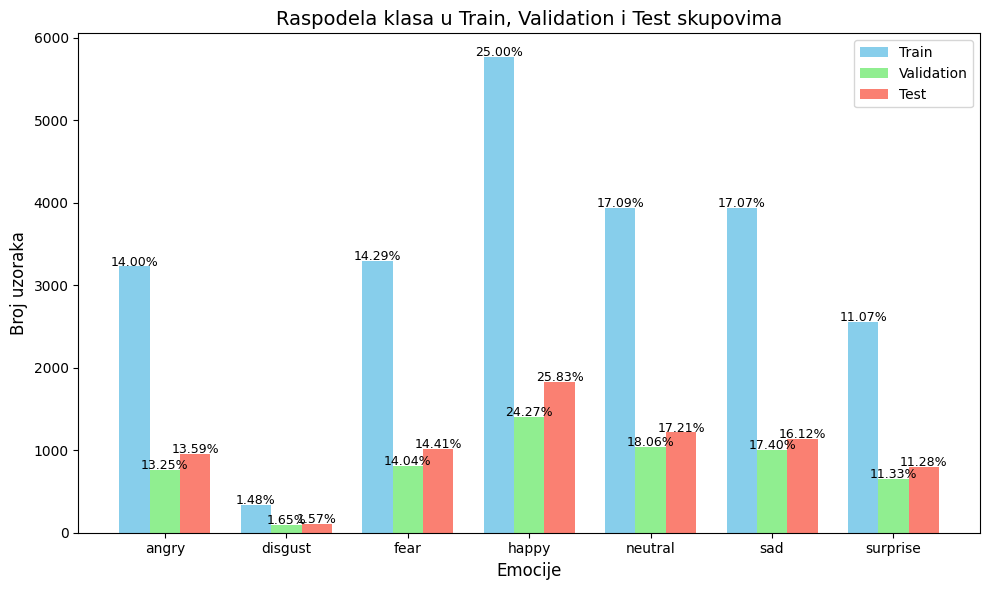

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Lista emocija
emotions = train_ds.class_names

# Konvertujemo counts u listu vrednosti po redosledu emocija
train_values = [train_counts[cls] for cls in emotions]
val_values   = [val_counts[cls] for cls in emotions]
test_values  = [test_counts[cls] for cls in emotions]

# Isto za procente (stringovi)
train_perc_values = [train_perc[cls] for cls in emotions]
val_perc_values   = [val_perc[cls] for cls in emotions]
test_perc_values  = [test_perc[cls] for cls in emotions]

x = np.arange(len(emotions))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(x - width, train_values, width, label='Train', color='skyblue')
ax.bar(x, val_values, width, label='Validation', color='lightgreen')
ax.bar(x + width, test_values, width, label='Test', color='salmon')

ax.set_xlabel('Emocije', fontsize=12)
ax.set_ylabel('Broj uzoraka', fontsize=12)
ax.set_title('Raspodela klasa u Train, Validation i Test skupovima', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

# Dodavanje procenata iznad barova
for i in range(len(emotions)):
    ax.text(x[i]-width, train_values[i]+10, train_perc_values[i], ha='center', fontsize=9)
    ax.text(x[i], val_values[i]+10, val_perc_values[i], ha='center', fontsize=9)
    ax.text(x[i]+width, test_values[i]+10, test_perc_values[i], ha='center', fontsize=9)

plt.tight_layout()
plt.show()


<h1>NOVO UCITAVANJE PODATAKA SA OVERSAMPLINGOM ZA DISGUST</h1>

In [4]:
#dodato novo sa oversamplingom
import tensorflow as tf
import numpy as np
import os
import random

# --- Parametri ---
# train_val_data_dir = r'..\images\train'
train_val_data_dir = path + r'\images\train'
img_height = 48
img_width = 48
batch_size = 128
target_class = 'disgust'
target_count = 4000

# --- Učitaj sve slike u memoriju (kao test DS, bez split) ---
all_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=1,   # batch=1 da dobijemo pojedinačne slike
    shuffle=True,
    color_mode='grayscale'
)

class_names = all_ds.class_names
num_classes = len(class_names)
target_idx = class_names.index(target_class)
print("Sve klase:", class_names)

# --- Razdvoji slike po klasama ---
images_per_class = {i: [] for i in range(num_classes)}
labels_per_class = {i: [] for i in range(num_classes)}

for img, lbl in all_ds.unbatch():
    cls_idx = tf.argmax(lbl).numpy()
    images_per_class[cls_idx].append(img.numpy())
    labels_per_class[cls_idx].append(lbl.numpy())

# --- Oversampling ciljne klase ---
current_count = len(images_per_class[target_idx])
if current_count < target_count:
    extra_idx = np.random.choice(current_count, target_count - current_count, replace=True)
    for i in extra_idx:
        images_per_class[target_idx].append(images_per_class[target_idx][i])
        labels_per_class[target_idx].append(labels_per_class[target_idx][i])

# --- Spoji sve klase ---
all_images = []
all_labels = []
for i in range(num_classes):
    all_images.extend(images_per_class[i])
    all_labels.extend(labels_per_class[i])

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# --- Permutacija da batch-evi budu mešani ---
perm = np.random.permutation(len(all_images))
all_images = all_images[perm]
all_labels = all_labels[perm]

# --- Stratified split 80/20 po klasama ---
train_images, val_images = [], []
train_labels, val_labels = [], []

for cls in range(num_classes):
    cls_indices = np.where(np.argmax(all_labels, axis=1) == cls)[0]
    split_idx = int(len(cls_indices) * 0.8)
    train_idx = cls_indices[:split_idx]
    val_idx = cls_indices[split_idx:]
    
    train_images.append(all_images[train_idx])
    train_labels.append(all_labels[train_idx])
    val_images.append(all_images[val_idx])
    val_labels.append(all_labels[val_idx])

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# --- Permutacija nakon split-a ---
perm_train = np.random.permutation(len(train_images))
train_images = train_images[perm_train]
train_labels = train_labels[perm_train]

perm_val = np.random.permutation(len(val_images))
val_images = val_images[perm_val]
val_labels = val_labels[perm_val]

# --- Kreiraj batch-eve kao image_dataset_from_directory ---
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))  # shuffle pre batch-a
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.shuffle(buffer_size=len(val_images))  # opcionalno, obično se ne shuffle val
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


train_ds.class_names = class_names
val_ds.class_names = class_names

print("Train shape:", train_images.shape, train_labels.shape)
print("Val shape:", val_images.shape, val_labels.shape)


Found 28821 files belonging to 7 classes.
Sve klase: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train shape: (25906, 48, 48, 1) (25906, 7)
Val shape: (6479, 48, 48, 1) (6479, 7)


In [300]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [5]:
# test DS
batch_size = 128
# test_data_dir = r'..\images\test'
test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)

Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Broj slika u originalnom datasetu:
        
        - training 28821
        
        - validation (test kod nas) 7066

In [5]:
def show_first_images_by_category_grayscale(dataset): 
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        #class_names = train_ds.class_names
    
        first_of_class = {}  # prva slika po klasi
    
        for i in range(len(images)):
            class_index = np.argmax(labels[i])
            class_name = class_names[class_index]
    
            if class_name not in first_of_class:
                first_of_class[class_name] = images[i]
    
            if len(first_of_class) == len(class_names):
                break
    
        # broj klasa
        n_classes = len(class_names)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona
    
        for ax, (class_name, image) in zip(axes, first_of_class.items()):
            ax.imshow(image.squeeze(), cmap='gray')  # squeeze ako je grayscale
            ax.set_title(class_name)
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

In [6]:
# Metoda koja prikazuje po jednu sliku iz svake kategorije - rgb 
def show_first_images_by_category_rgb(dataset):   
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        #class_names = train_ds.class_names
    
        first_of_class = {}  # prva slika po klasi
    
        for i in range(len(images)):
            class_index = np.argmax(labels[i])
            class_name = class_names[class_index]
    
            if class_name not in first_of_class:
                first_of_class[class_name] = images[i]
    
            if len(first_of_class) == len(class_names):
                break
    
        # broj klasa
        n_classes = len(class_names)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona
    
        for ax, (class_name, image) in zip(axes, first_of_class.items()):
            ax.imshow(image) 
            ax.set_title(class_name)
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

<h3 style="color: #ab5bb0">Prebrojavanje slika po kategorijama:</h3>

In [7]:
def count_labels(dataset):
    counts = dict.fromkeys(class_names, 0)
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[class_names[i]] += 1
    return counts



print("Train dataset:", count_labels(train_ds))
print("Validation dataset:", count_labels(val_ds))
print("Test dataset:", count_labels(test_ds))


NameError: name 'class_names' is not defined

<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - nisu jos normalizovane niti konv. u rgb</h3>

In [287]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [8]:
show_first_images_by_category_grayscale(train_ds)

NameError: name 'class_names' is not defined

<h4>Normalizacija:</h4>

In [9]:
def normalize_images(x, y):
    x = tf.cast(x, tf.float32)
    x = (x - 0) / (255 - 0)      # min-max normalizacija
    return x, y

# primjena na sve dataset-ove
train_ds = train_ds.map(normalize_images)
val_ds   = val_ds.map(normalize_images)
test_ds  = test_ds.map(normalize_images)

In [10]:
for x, y in train_ds.take(1):
    print(x.shape)  # (batch_size, img_height, img_width, 1)

(128, 48, 48, 1)


Provjera px:

Train set - Min pixel: 0.0, Max pixel: 1.0
Validation set - Min pixel: 0.0, Max pixel: 1.0
Test set - Min pixel: 0.0, Max pixel: 1.0


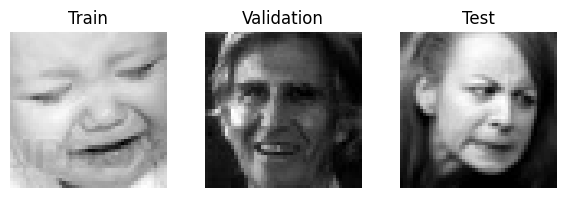

In [11]:
# Metoda koja prikazuje po 1 sliku iz train test i validation skupova
def show_first_images_in_row(train_ds, val_ds, test_ds):
    datasets = [train_ds, val_ds, test_ds]
    names = ["Train", "Validation", "Test"]
    images_to_show = []

    # uzmi prvu sliku iz svakog skupa
    for dataset, name in zip(datasets, names):
        for images, labels in dataset.take(1):
            image = images[0].numpy().squeeze()  # prva slika
            min_val = tf.reduce_min(images).numpy()
            max_val = tf.reduce_max(images).numpy()
            print(f"{name} set - Min pixel: {min_val}, Max pixel: {max_val}")
            images_to_show.append((image, name))

    # prikaz slika u jednom redu
    fig, axes = plt.subplots(1, len(images_to_show), figsize=(len(images_to_show)*2, 2))
    for ax, (image, name) in zip(axes, images_to_show):
        ax.imshow(image, cmap='gray')
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_first_images_in_row(train_ds, val_ds, test_ds)

<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - normalizovane, nisu konv. u rgb</h3>

In [12]:
show_first_images_by_category_grayscale(train_ds)

NameError: name 'class_names' is not defined

Augmentacija train seta:

In [13]:
# Data augmentation - pozvati u modelu
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2)
])

<h4>GRAYSLACE TO RGB:</h4>

In [294]:
def preprocess_to_rgb(img, label):
    img = tf.image.grayscale_to_rgb(img)  # 1 kanal -> 3 kanala
    return img, label

train_ds_rgb = train_ds.map(preprocess_to_rgb)
val_ds_rgb = val_ds.map(preprocess_to_rgb)
test_ds_rgb = test_ds.map(preprocess_to_rgb)

for x, y in train_ds_rgb.take(1):
    print(x.shape)  # (batch_size, img_height, img_width, 3)


(128, 48, 48, 3)


<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - normalizovane, konv. u rgb</h3>

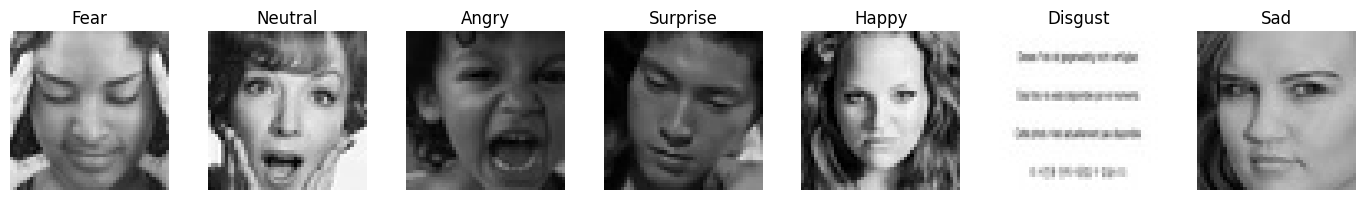

In [295]:
show_first_images_by_category_rgb(train_ds_rgb)

In [296]:
import matplotlib.pyplot as plt
import numpy as np

# Metoda koja prikazuje sliku u realnoj velicini (za poredjenje prilikom resize-a)
def show_first_image_real_size(dataset, dpi=100):
    # 1. batch
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        break
    
    # 1. slika
    image = images[0]
    
    h, w = image.shape[:2]

    fig_width = w / dpi
    fig_height = h / dpi

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    ax.imshow(image)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    plt.show()


In [297]:
def resize_images(x, y, h=128, w=128):
    #x = tf.image.resize(x, [h, w], method='nearest')
    x = tf.image.resize(x, [h, w], method=tf.image.ResizeMethod.BILINEAR)

    return x, y

<h1 style="color: #16537e">VGGNET 19</h1>
parametri (podesiti, i iz radova) i rez, analiza, fine tuning! 

In [131]:
train_ds_rgb_1 = train_ds_rgb.map(lambda x, y: resize_images(x, y, h=128, w=128))
val_ds_rgb_1   = val_ds_rgb.map(lambda x, y: resize_images(x, y, h=128, w=128))
test_ds_rgb_1  = test_ds_rgb.map(lambda x, y: resize_images(x, y, h=128, w=128))

In [87]:
for x, y in train_ds_rgb_1.take(1):
    print(x.shape) 

(128, 128, 128, 3)


Prikazujemo po jednu prvu sliku iz test skupa (jer se u njemu redoslijed slika ne mijesaja kad im se pristupa):

Dimenzije slike: (48, 48, 3)


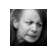

Dimenzije slike: (128, 128, 3)


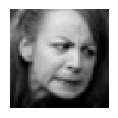

In [88]:
for x, y in train_ds_rgb.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb)

for x, y in train_ds_rgb_1.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb_1)

In [89]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parametri
img_height = 128
img_width = 128
num_classes = 7
batch_size = 256
learning_rate = 5e-3
epochs = 40

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),          
    layers.RandomRotation(0.15),              
    layers.RandomTranslation(0.15, 0.15),     
    layers.RandomZoom(0.15),                 
    layers.RandomTranslation(0.0, 0.0),      
])

# Build VGG19 model
vgg_base = VGG19(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in vgg_base.layers:
    layer.trainable = False

inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = vgg_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_ds_rgb_1,
    validation_data=val_ds_rgb_1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluate
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_1)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))

Epoch 1/40
  2/181 ━━━━━━━━━━━━━━━━━━━━ 34:28 12s/step - accuracy: 0.1133 - auc: 0.4983 - loss: 2.3636 - precision: 0.0819 - recall: 0.0137  

KeyboardInterrupt: 

In [29]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)          │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_665              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,225,111 (77.15 MB)

 Trainable params: 66,823 (261.03 KB)

 Non-trainable params: 20,024,640 (76.39 MB)

 Optimizer params: 133,648 (522.07 KB)

In [11]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

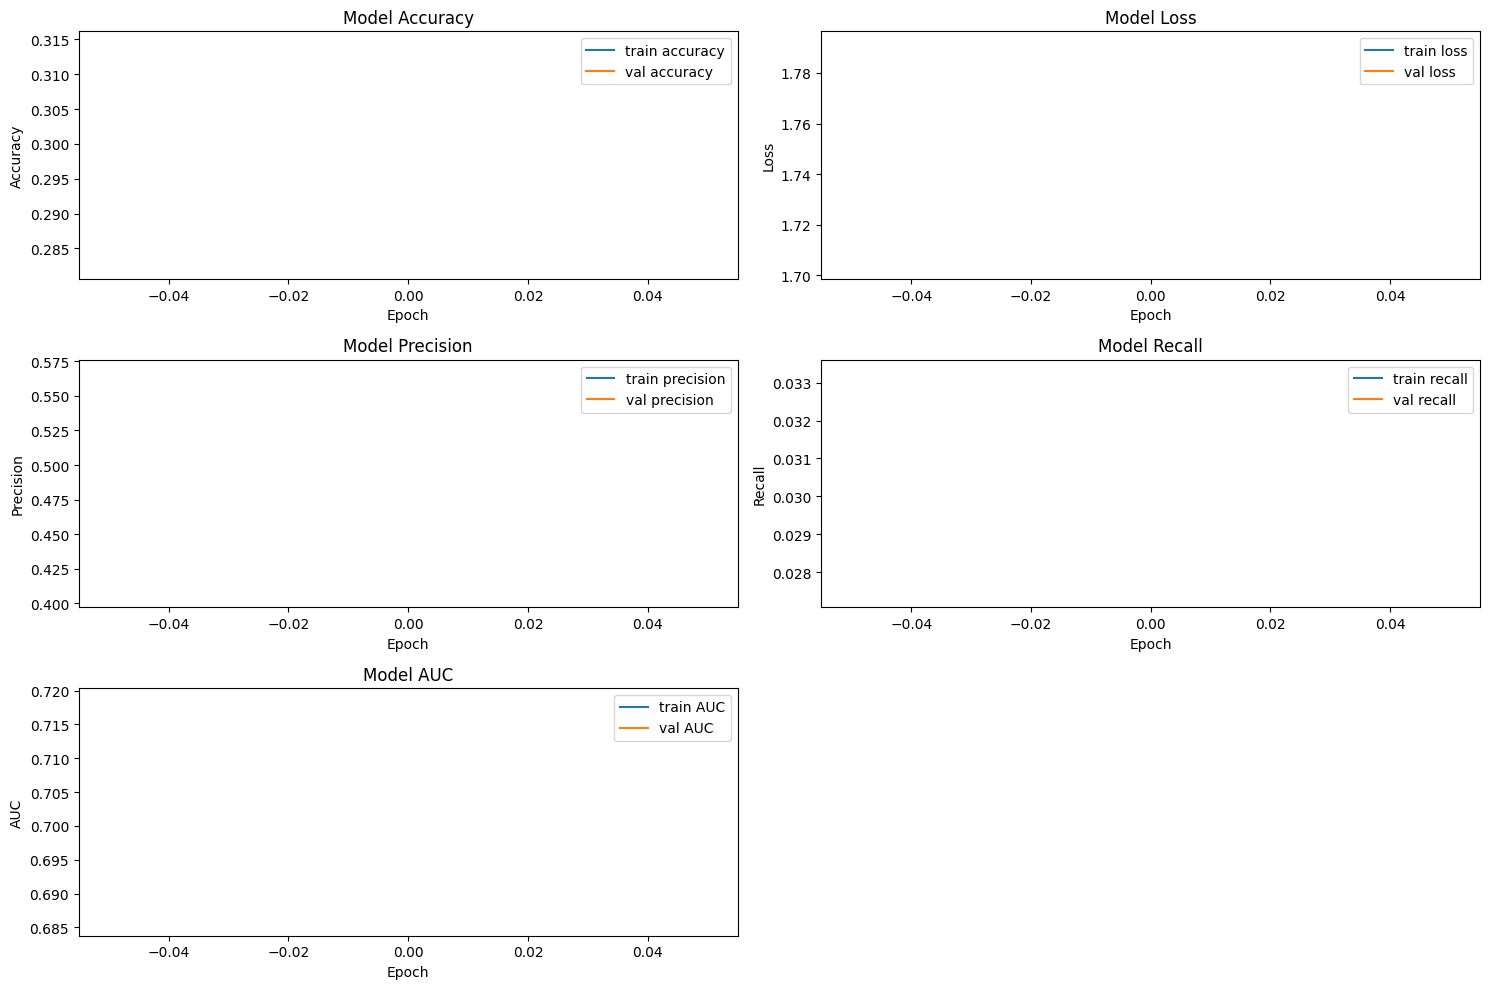

In [16]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()


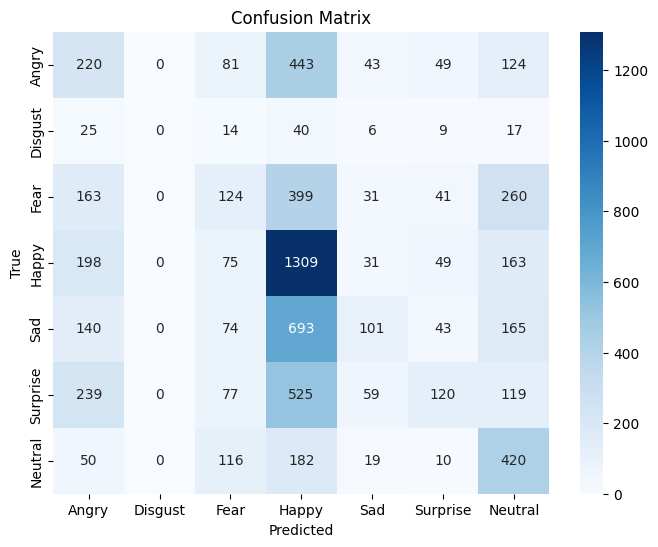

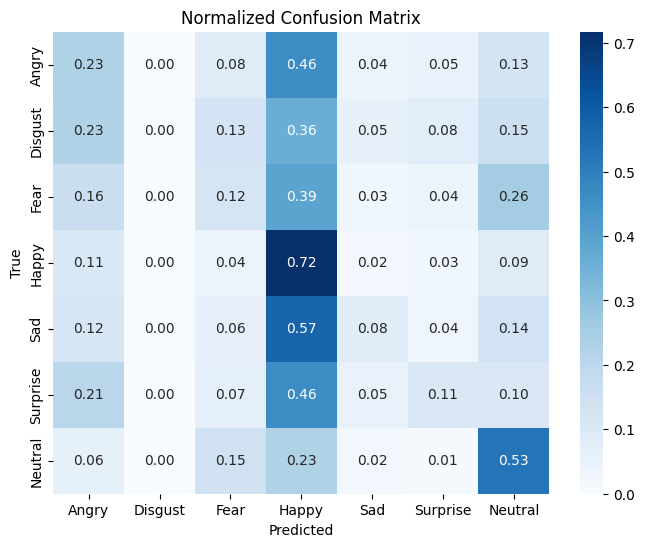

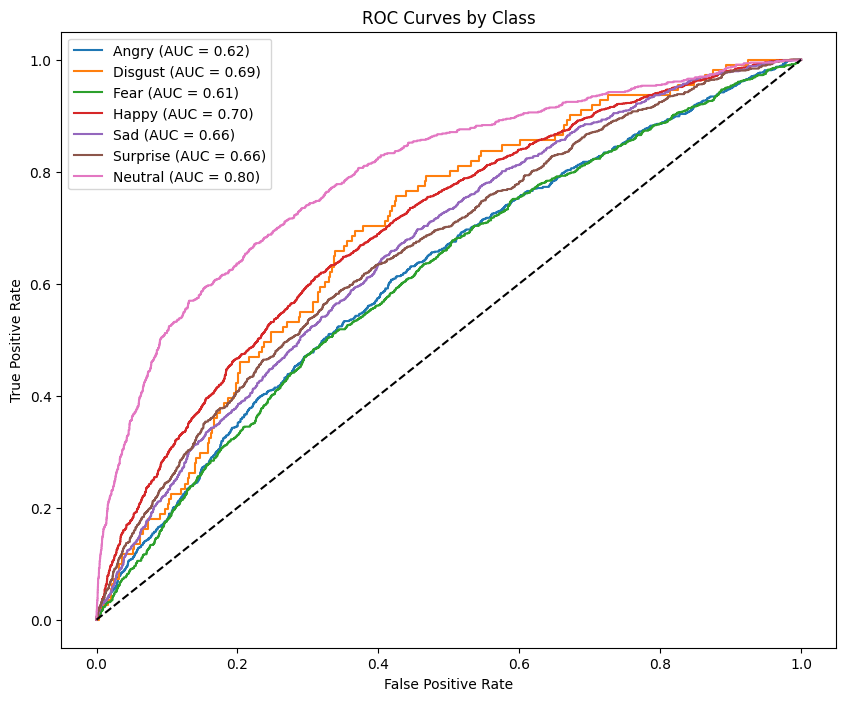

In [15]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()




<h1 style="color: #16537e">GOOGLENET INCEPTION V3</h1>

In [269]:
train_ds_rgb_2 = train_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))
val_ds_rgb_2   = val_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))
test_ds_rgb_2  = test_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))

In [270]:
for x, y in train_ds_rgb_2.take(1):
    print(x.shape) 

(128, 130, 130, 3)


Dimenzije slike: (48, 48, 3)


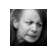

Dimenzije slike: (130, 130, 3)


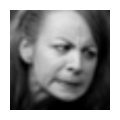

In [271]:
for x, y in train_ds_rgb.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb)

for x, y in train_ds_rgb_2.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb_2)

In [279]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, f1_score

# Parametri
img_height = 130
img_width = 130
num_classes = 7
batch_size = 128
learning_rate = 5e-4
epochs = 40

# Data augmentation 
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.15)
])

# Build InceptionV3 model
inception_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in inception_base.layers:
    layer.trainable = False

inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = inception_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_inception_model.keras', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_ds_rgb_2,
    validation_data=val_ds_rgb_2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluate
best_model = load_model('best_inception_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_2)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report 
y_true = np.concatenate([y for x, y in test_ds_rgb_2], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_2)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/40
 93/203 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - accuracy: 0.2115 - auc: 0.5872 - loss: 2.2839 - precision: 0.2444 - recall: 0.0743

KeyboardInterrupt: 

In [274]:
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)          │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_19 (Sequential)           │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1039             │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,593,335 (86.19 MB)

 Trainable params: 263,431 (1.00 MB)

 Non-trainable params: 21,803,040 (83.17 MB)

 Optimizer params: 526,864 (2.01 MB)

In [275]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

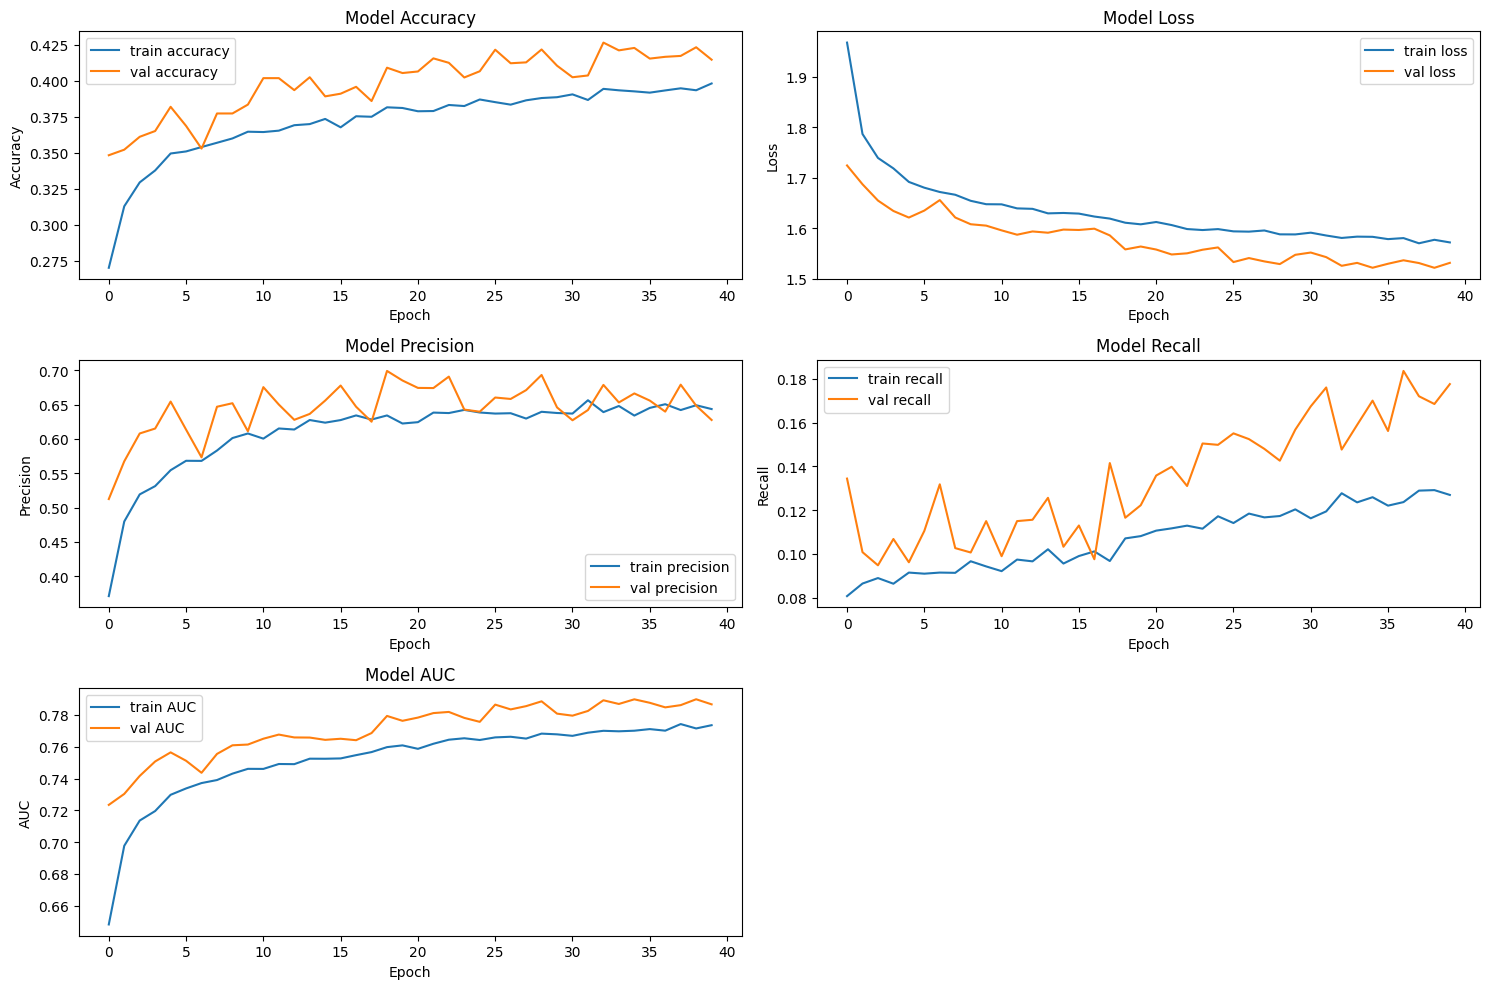

In [276]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()


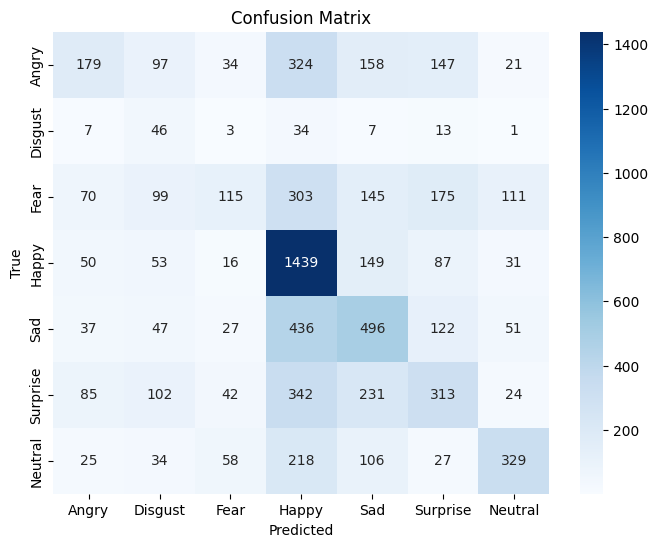

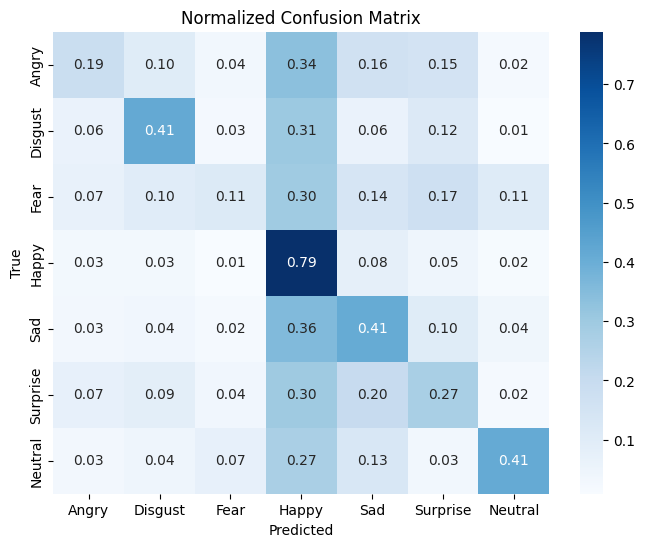

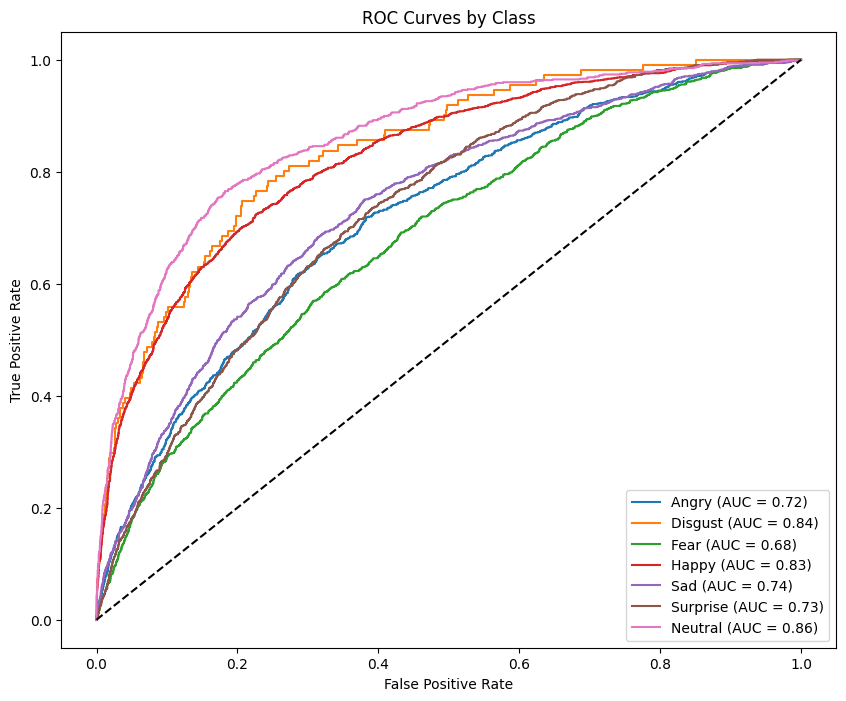

In [277]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()




In [278]:
# --- Fine-tuning poslednjeg bloka ---
# Otvori poslednji block za treniranje
fine_tune_epochs = 15
fine_tune_at = 249  # poslednji InceptionV3 block
for layer in inception_base.layers[:fine_tune_at]:
    layer.trainable = False
for layer in inception_base.layers[fine_tune_at:]:
    layer.trainable = True

# --- Optimizer za fine-tuning (manji LR) ---
fine_tune_optimizer = optimizers.Adam(learning_rate=learning_rate, amsgrad=True)

model.compile(
    optimizer=fine_tune_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# --- Nastavi treniranje (fine-tune) ---
history_fine = model.fit(
    train_ds_rgb_2,
    validation_data=val_ds_rgb_2,
    epochs=epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# --- Evaluacija ---
best_model = load_model('best_inception_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_2)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# --- F1 score i classification report ---
y_true = np.concatenate([y for x, y in test_ds_rgb_2], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_2)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))

Epoch 40/55
203/203 ━━━━━━━━━━━━━━━━━━━━ 760s 4s/step - accuracy: 0.3787 - auc: 0.7566 - loss: 1.6240 - precision: 0.6155 - recall: 0.1332 - val_accuracy: 0.4513 - val_auc: 0.8115 - val_loss: 1.5050 - val_precision: 0.6072 - val_recall: 0.2894 - learning_rate: 5.0000e-04
Epoch 41/55
203/203 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.4578 - auc: 0.8162 - loss: 1.4393 - precision: 0.6877 - recall: 0.2212 - val_accuracy: 0.4925 - val_auc: 0.8451 - val_loss: 1.3392 - val_precision: 0.6832 - val_recall: 0.3139 - learning_rate: 5.0000e-04
Epoch 42/55
203/203 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step - accuracy: 0.4876 - auc: 0.8367 - loss: 1.3636 - precision: 0.7044 - recall: 0.2637 - val_accuracy: 0.5289 - val_auc: 0.8632 - val_loss: 1.2693 - val_precision: 0.6834 - val_recall: 0.3744 - learning_rate: 5.0000e-04
Epoch 43/55
203/203 ━━━━━━━━━━━━━━━━━━━━ 747s 4s/step - accuracy: 0.5022 - auc: 0.8464 - loss: 1.3263 - precision: 0.7156 - recall: 0.2895 - val_accuracy: 0.5343 - val_auc: 0.8680 - va

ANJA LOVRIC

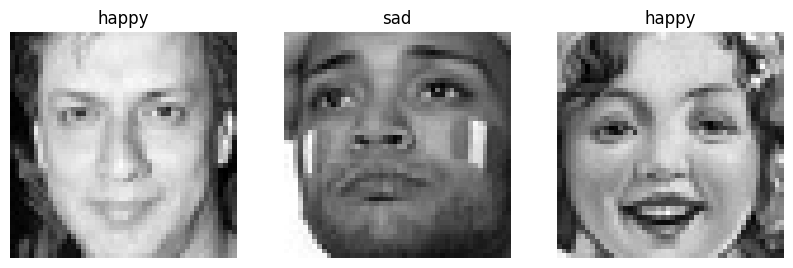

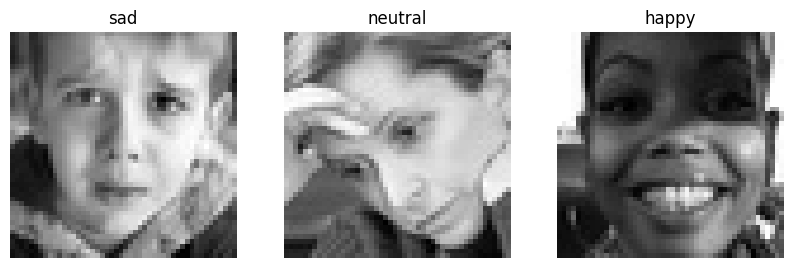

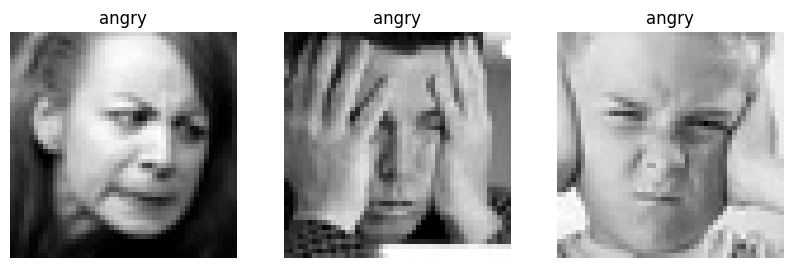

In [11]:
import matplotlib.pyplot as plt

train_class_names = train_ds.class_names
class_names = train_class_names
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  
    for i in range(3): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray") 
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

class_names = val_ds.class_names
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):  
    for i in range(3): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray") 
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")


class_names = test_class_names
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):  
    for i in range(3): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray") 
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

In [30]:
def count_labels_with_percentage(dataset, class_names):
    counts = dict.fromkeys(class_names, 0)
    total = 0
    
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[class_names[i]] += 1
        total += len(indices)
    percentages = {cls: f"{(counts[cls]/total)*100:.2f}%" for cls in class_names}
    
    return counts, percentages


train_counts, train_perc = count_labels_with_percentage(train_ds, class_names)
val_counts, val_perc = count_labels_with_percentage(val_ds, class_names)
test_counts, test_perc = count_labels_with_percentage(test_ds, class_names)

print("Train dataset counts:", train_counts)
print("Train dataset %:", train_perc)

print("\nValidation dataset counts:", val_counts)
print("Validation dataset %:", val_perc)

print("\nTest dataset counts:", test_counts)
print("Test dataset %:", test_perc)


Train dataset counts: {'angry': 3194, 'disgust': 3200, 'fear': 3282, 'happy': 5731, 'neutral': 3985, 'sad': 3950, 'surprise': 2564}
Train dataset %: {'angry': '12.33%', 'disgust': '12.35%', 'fear': '12.67%', 'happy': '22.12%', 'neutral': '15.38%', 'sad': '15.25%', 'surprise': '9.90%'}

Validation dataset counts: {'angry': 799, 'disgust': 800, 'fear': 821, 'happy': 1433, 'neutral': 997, 'sad': 988, 'surprise': 641}
Validation dataset %: {'angry': '12.33%', 'disgust': '12.35%', 'fear': '12.67%', 'happy': '22.12%', 'neutral': '15.39%', 'sad': '15.25%', 'surprise': '9.89%'}

Test dataset counts: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}
Test dataset %: {'angry': '13.59%', 'disgust': '1.57%', 'fear': '14.41%', 'happy': '25.83%', 'neutral': '17.21%', 'sad': '16.12%', 'surprise': '11.28%'}


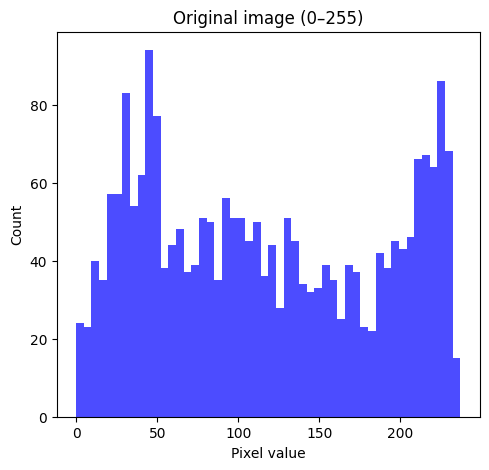

In [31]:
import matplotlib.pyplot as plt
import tensorflow as tf

images_orig, _ = next(iter(train_ds))
img_orig = images_orig[0].numpy().squeeze()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(img_orig.flatten(), bins=50, color="blue", alpha=0.7)
plt.title("Original image (0–255)")
plt.xlabel("Pixel value")
plt.ylabel("Count")


plt.show()


In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Original min: 0.0
Original max: 1.0
Original min: 0.0
Original max: 1.0
Original min: 0.0
Original max: 1.0
Mean: 0.50950694
Std: 0.24740091


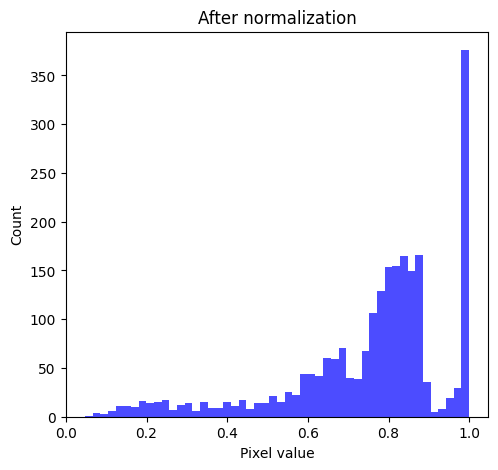

In [33]:
#Testing pixel values after normalizaton
for images, labels in train_ds.take(1):
    print("Original min:", tf.reduce_min(images).numpy())
    print("Original max:", tf.reduce_max(images).numpy())

for images, labels in val_ds.take(1):
    print("Original min:", tf.reduce_min(images).numpy())
    print("Original max:", tf.reduce_max(images).numpy())

for images, labels in test_ds.take(1):
    print("Original min:", tf.reduce_min(images).numpy())
    print("Original max:", tf.reduce_max(images).numpy())

for images, _ in train_ds.take(1):
    print("Mean:", tf.reduce_mean(images).numpy())
    print("Std:", tf.math.reduce_std(images).numpy())

import matplotlib.pyplot as plt
import tensorflow as tf

images_orig, _ = next(iter(train_ds))
img_orig = images_orig[0].numpy().squeeze()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(img_orig.flatten(), bins=50, color="blue", alpha=0.7)
plt.title("After normalization")
plt.xlabel("Pixel value")
plt.ylabel("Count")


plt.show()

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    # tf.keras.layers.RandomZoom(0.1),
    # tf.keras.layers.RandomTranslation(0.1, 0.1),
])


In [16]:
import tensorflow as tf

def macro_f1(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_true, axis=1)
    
    y_pred = tf.cast(y_pred, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    f1s = []
    num_classes = 7
    for i in range(num_classes):
        tp = tf.reduce_sum(tf.cast((y_true==i) & (y_pred==i), tf.float32))
        fp = tf.reduce_sum(tf.cast((y_true!=i) & (y_pred==i), tf.float32))
        fn = tf.reduce_sum(tf.cast((y_true==i) & (y_pred!=i), tf.float32))
        f1 = 2*tp/(2*tp + fp + fn + 1e-16)
        f1s.append(f1)
    return tf.reduce_mean(f1s)

<h1 style="color: #16537e">RESNET 50</h1>

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
#batch size 64, augmentation all transformation in the function

inputs = layers.Input(shape=(48,48,1))
x = data_augmentation(inputs)    
x = layers.Conv2D(3, (3,3), padding='same')(inputs)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48,48,3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model(x, training=False)      
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[macro_f1, 'accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

#Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

loss, f1, acc, prec, rec, auc = model.evaluate(test_ds)
print(f"F1 Macro: {f1:.3f}, Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")


Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.2033 - auc: 0.6012 - loss: 1.9279 - macro_f1: 0.0506 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 51s 263ms/step - accuracy: 0.2367 - auc: 0.6331 - loss: 1.8405 - macro_f1: 0.0556 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2427 - val_auc: 0.6422 - val_loss: 1.8162 - val_macro_f1: 0.0557 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.2498 - auc: 0.6455 - loss: 1.8099 - macro_f1: 0.0569 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 48s 261ms/step - accuracy: 0.2501 - auc: 0.6467 - loss: 1.8069 - macro_f1: 0.0571 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2427 - val_auc: 0.6529 - val_loss: 1.8092 - val_macro_f1: 0.0564 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2493 - auc: 0.6490 - loss: 1.8068 - macro_f1: 0.0574 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 47s 260ms/step - accuracy: 0.2502 - auc: 0.6509 - loss: 1.8028 - macro_f1: 0.0587 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2425 - val_auc: 0.6557 - val_loss: 1.8037 - val_macro_f1: 0.0546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.2466 - auc: 0.6566 - loss: 1.7997 - macro_f1: 0.0602 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 47s 257ms/step - accuracy: 0.2497 - auc: 0.6599 - loss: 1.7938 - macro_f1: 0.0622 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2444 - val_auc: 0.6645 - val_loss: 1.7938 - val_macro_f1: 0.0715 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.2465 - auc: 0.6631 - loss: 1.7923 - macro_f1: 0.0781 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 272ms/step - accuracy: 0.2524 - auc: 0.6676 - loss: 1.7858 - macro_f1: 0.0782 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2483 - val_auc: 0.6706 - val_loss: 1.7856 - val_macro_f1: 0.0823 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.2585 - auc: 0.6727 - loss: 1.7816 - macro_f1: 0.0938 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - accuracy: 0.2596 - auc: 0.6754 - loss: 1.7769 - macro_f1: 0.0984 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2505 - val_auc: 0.6749 - val_loss: 1.7791 - val_macro_f1: 0.0978 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.2616 - auc: 0.6793 - loss: 1.7731 - macro_f1: 0.1085 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 270ms/step - accuracy: 0.2644 - auc: 0.6819 - loss: 1.7692 - macro_f1: 0.1131 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2547 - val_auc: 0.6791 - val_loss: 1.7753 - val_macro_f1: 0.1082 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.2673 - auc: 0.6814 - loss: 1.7698 - macro_f1: 0.1251 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - accuracy: 0.2688 - auc: 0.6858 - loss: 1.7631 - macro_f1: 0.1278 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2566 - val_auc: 0.6860 - val_loss: 1.7676 - val_macro_f1: 0.1119 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.2705 - auc: 0.6877 - loss: 1.7618 - macro_f1: 0.1345 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 270ms/step - accuracy: 0.2746 - auc: 0.6913 - loss: 1.7557 - macro_f1: 0.1404 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2719 - val_auc: 0.6936 - val_loss: 1.7564 - val_macro_f1: 0.1496 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.2799 - auc: 0.6937 - loss: 1.7536 - macro_f1: 0.1530 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 269ms/step - accuracy: 0.2810 - auc: 0.6969 - loss: 1.7478 - macro_f1: 0.1536 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2786 - val_auc: 0.6974 - val_loss: 1.7498 - val_macro_f1: 0.1652 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 11/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.2840 - auc: 0.6965 - loss: 1.7478 - macro_f1: 0.1627 - precision: 0.0000e+00 - recall: 0.0000e+00

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 274ms/step - accuracy: 0.2862 - auc: 0.7011 - loss: 1.7404 - macro_f1: 0.1644 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2783 - val_auc: 0.6997 - val_loss: 1.7447 - val_macro_f1: 0.1556 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 12/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.2887 - auc: 0.7011 - loss: 1.7400 - macro_f1: 0.1676 - precision: 0.3425 - recall: 3.5011e-05

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - accuracy: 0.2916 - auc: 0.7052 - loss: 1.7337 - macro_f1: 0.1726 - precision: 1.0000 - recall: 8.6742e-05 - val_accuracy: 0.2887 - val_auc: 0.7041 - val_loss: 1.7383 - val_macro_f1: 0.1808 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 13/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.2919 - auc: 0.7055 - loss: 1.7337 - macro_f1: 0.1766 - precision: 0.7343 - recall: 2.6529e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 269ms/step - accuracy: 0.2921 - auc: 0.7088 - loss: 1.7275 - macro_f1: 0.1777 - precision: 0.8750 - recall: 3.0360e-04 - val_accuracy: 0.2814 - val_auc: 0.7055 - val_loss: 1.7336 - val_macro_f1: 0.1574 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 14/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.2931 - auc: 0.7084 - loss: 1.7271 - macro_f1: 0.1805 - precision: 0.6834 - recall: 7.0761e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 271ms/step - accuracy: 0.2978 - auc: 0.7119 - loss: 1.7213 - macro_f1: 0.1854 - precision: 0.7391 - recall: 7.3730e-04 - val_accuracy: 0.3019 - val_auc: 0.7115 - val_loss: 1.7257 - val_macro_f1: 0.2021 - val_precision: 0.6000 - val_recall: 5.2047e-04
Epoch 15/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3021 - auc: 0.7120 - loss: 1.7198 - macro_f1: 0.1957 - precision: 0.5669 - recall: 0.0010

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 272ms/step - accuracy: 0.3041 - auc: 0.7149 - loss: 1.7148 - macro_f1: 0.1940 - precision: 0.6250 - recall: 0.0011 - val_accuracy: 0.3144 - val_auc: 0.7161 - val_loss: 1.7205 - val_macro_f1: 0.2255 - val_precision: 0.7778 - val_recall: 0.0012
Epoch 16/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3046 - auc: 0.7148 - loss: 1.7139 - macro_f1: 0.1956 - precision: 0.6809 - recall: 0.0022

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 270ms/step - accuracy: 0.3081 - auc: 0.7177 - loss: 1.7091 - macro_f1: 0.1977 - precision: 0.6769 - recall: 0.0019 - val_accuracy: 0.3073 - val_auc: 0.7157 - val_loss: 1.7162 - val_macro_f1: 0.2022 - val_precision: 0.6667 - val_recall: 0.0017
Epoch 17/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3089 - auc: 0.7174 - loss: 1.7104 - macro_f1: 0.2023 - precision: 0.6188 - recall: 0.0025

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 271ms/step - accuracy: 0.3106 - auc: 0.7213 - loss: 1.7030 - macro_f1: 0.2036 - precision: 0.6735 - recall: 0.0029 - val_accuracy: 0.3147 - val_auc: 0.7194 - val_loss: 1.7103 - val_macro_f1: 0.2146 - val_precision: 0.5833 - val_recall: 0.0036
Epoch 18/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.3117 - auc: 0.7204 - loss: 1.7039 - macro_f1: 0.2104 - precision: 0.7033 - recall: 0.0047

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 270ms/step - accuracy: 0.3148 - auc: 0.7230 - loss: 1.6994 - macro_f1: 0.2096 - precision: 0.7254 - recall: 0.0045 - val_accuracy: 0.3062 - val_auc: 0.7174 - val_loss: 1.7092 - val_macro_f1: 0.1930 - val_precision: 0.6667 - val_recall: 0.0049
Epoch 19/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.3173 - auc: 0.7213 - loss: 1.7011 - macro_f1: 0.2120 - precision: 0.6240 - recall: 0.0050

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 269ms/step - accuracy: 0.3186 - auc: 0.7249 - loss: 1.6948 - macro_f1: 0.2144 - precision: 0.6606 - recall: 0.0047 - val_accuracy: 0.3230 - val_auc: 0.7201 - val_loss: 1.7061 - val_macro_f1: 0.2238 - val_precision: 0.6316 - val_recall: 0.0062
Epoch 20/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3170 - auc: 0.7239 - loss: 1.6954 - macro_f1: 0.2143 - precision: 0.6705 - recall: 0.0066

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 271ms/step - accuracy: 0.3193 - auc: 0.7270 - loss: 1.6901 - macro_f1: 0.2170 - precision: 0.7115 - recall: 0.0064 - val_accuracy: 0.3213 - val_auc: 0.7242 - val_loss: 1.6978 - val_macro_f1: 0.2230 - val_precision: 0.6667 - val_recall: 0.0066
Epoch 21/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.3273 - auc: 0.7270 - loss: 1.6887 - macro_f1: 0.2266 - precision: 0.6497 - recall: 0.0073

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 270ms/step - accuracy: 0.3259 - auc: 0.7282 - loss: 1.6871 - macro_f1: 0.2235 - precision: 0.6615 - recall: 0.0075 - val_accuracy: 0.3279 - val_auc: 0.7242 - val_loss: 1.6976 - val_macro_f1: 0.2242 - val_precision: 0.6857 - val_recall: 0.0083
Epoch 22/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.3238 - auc: 0.7277 - loss: 1.6880 - macro_f1: 0.2257 - precision: 0.6617 - recall: 0.0093

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - accuracy: 0.3287 - auc: 0.7309 - loss: 1.6819 - macro_f1: 0.2284 - precision: 0.6781 - recall: 0.0094 - val_accuracy: 0.3319 - val_auc: 0.7271 - val_loss: 1.6950 - val_macro_f1: 0.2468 - val_precision: 0.6575 - val_recall: 0.0083
Epoch 23/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3311 - auc: 0.7306 - loss: 1.6818 - macro_f1: 0.2338 - precision: 0.6851 - recall: 0.0103

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 272ms/step - accuracy: 0.3304 - auc: 0.7325 - loss: 1.6784 - macro_f1: 0.2300 - precision: 0.6753 - recall: 0.0113 - val_accuracy: 0.3361 - val_auc: 0.7300 - val_loss: 1.6914 - val_macro_f1: 0.2564 - val_precision: 0.6377 - val_recall: 0.0076
Epoch 24/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.3323 - auc: 0.7329 - loss: 1.6768 - macro_f1: 0.2370 - precision: 0.6688 - recall: 0.0109

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 275ms/step - accuracy: 0.3327 - auc: 0.7349 - loss: 1.6732 - macro_f1: 0.2351 - precision: 0.6658 - recall: 0.0115 - val_accuracy: 0.3348 - val_auc: 0.7302 - val_loss: 1.6848 - val_macro_f1: 0.2362 - val_precision: 0.6727 - val_recall: 0.0128
Epoch 25/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.3319 - auc: 0.7333 - loss: 1.6765 - macro_f1: 0.2347 - precision: 0.6738 - recall: 0.0144

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 274ms/step - accuracy: 0.3342 - auc: 0.7359 - loss: 1.6706 - macro_f1: 0.2346 - precision: 0.6747 - recall: 0.0145 - val_accuracy: 0.3354 - val_auc: 0.7307 - val_loss: 1.6819 - val_macro_f1: 0.2324 - val_precision: 0.6589 - val_recall: 0.0147
Epoch 26/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - accuracy: 0.3383 - auc: 0.7375 - loss: 1.6668 - macro_f1: 0.2401 - precision: 0.6766 - recall: 0.0158 - val_accuracy: 0.3477 - val_auc: 0.7327 - val_loss: 1.6833 - val_macro_f1: 0.2664 - val_precision: 0.6556 - val_recall: 0.0102
Epoch 27/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.3380 - auc: 0.7371 - loss: 1.6675 - macro_f1: 0.2461 - precision: 0.6766 - recall: 0.0170

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 275ms/step - accuracy: 0.3389 - auc: 0.7388 - loss: 1.6638 - macro_f1: 0.2427 - precision: 0.6758 - recall: 0.0183 - val_accuracy: 0.3413 - val_auc: 0.7344 - val_loss: 1.6781 - val_macro_f1: 0.2543 - val_precision: 0.6417 - val_recall: 0.0134
Epoch 28/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.3352 - auc: 0.7377 - loss: 1.6650 - macro_f1: 0.2396 - precision: 0.6777 - recall: 0.0208

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.3382 - auc: 0.7398 - loss: 1.6611 - macro_f1: 0.2420 - precision: 0.6649 - recall: 0.0216 - val_accuracy: 0.3371 - val_auc: 0.7324 - val_loss: 1.6767 - val_macro_f1: 0.2300 - val_precision: 0.6461 - val_recall: 0.0272
Epoch 29/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3395 - auc: 0.7398 - loss: 1.6597 - macro_f1: 0.2447 - precision: 0.6814 - recall: 0.0211

181/181 ━━━━━━━━━━━━━━━━━━━━ 51s 282ms/step - accuracy: 0.3403 - auc: 0.7411 - loss: 1.6579 - macro_f1: 0.2431 - precision: 0.6676 - recall: 0.0212 - val_accuracy: 0.3433 - val_auc: 0.7361 - val_loss: 1.6747 - val_macro_f1: 0.2576 - val_precision: 0.6636 - val_recall: 0.0123
Epoch 30/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3430 - auc: 0.7406 - loss: 1.6591 - macro_f1: 0.2499 - precision: 0.6977 - recall: 0.0212

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 275ms/step - accuracy: 0.3436 - auc: 0.7432 - loss: 1.6539 - macro_f1: 0.2472 - precision: 0.6688 - recall: 0.0231 - val_accuracy: 0.3475 - val_auc: 0.7361 - val_loss: 1.6699 - val_macro_f1: 0.2454 - val_precision: 0.6554 - val_recall: 0.0201
Epoch 31/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.3449 - auc: 0.7413 - loss: 1.6562 - macro_f1: 0.2482 - precision: 0.6631 - recall: 0.0263

181/181 ━━━━━━━━━━━━━━━━━━━━ 122s 677ms/step - accuracy: 0.3461 - auc: 0.7441 - loss: 1.6511 - macro_f1: 0.2482 - precision: 0.6586 - recall: 0.0261 - val_accuracy: 0.3508 - val_auc: 0.7371 - val_loss: 1.6676 - val_macro_f1: 0.2491 - val_precision: 0.6696 - val_recall: 0.0260
Epoch 32/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.3455 - auc: 0.7440 - loss: 1.6498 - macro_f1: 0.2509 - precision: 0.7060 - recall: 0.0290

181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 471ms/step - accuracy: 0.3475 - auc: 0.7460 - loss: 1.6471 - macro_f1: 0.2522 - precision: 0.6868 - recall: 0.0281 - val_accuracy: 0.3459 - val_auc: 0.7387 - val_loss: 1.6654 - val_macro_f1: 0.2533 - val_precision: 0.6500 - val_recall: 0.0248
Epoch 33/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3494 - auc: 0.7447 - loss: 1.6477 - macro_f1: 0.2554 - precision: 0.7106 - recall: 0.0317

181/181 ━━━━━━━━━━━━━━━━━━━━ 46s 251ms/step - accuracy: 0.3507 - auc: 0.7464 - loss: 1.6453 - macro_f1: 0.2550 - precision: 0.6783 - recall: 0.0304 - val_accuracy: 0.3534 - val_auc: 0.7401 - val_loss: 1.6632 - val_macro_f1: 0.2607 - val_precision: 0.6684 - val_recall: 0.0227
Epoch 34/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.3513 - auc: 0.7470 - loss: 1.6433 - macro_f1: 0.2566 - precision: 0.6925 - recall: 0.0343

181/181 ━━━━━━━━━━━━━━━━━━━━ 47s 258ms/step - accuracy: 0.3522 - auc: 0.7483 - loss: 1.6416 - macro_f1: 0.2564 - precision: 0.6764 - recall: 0.0331 - val_accuracy: 0.3503 - val_auc: 0.7398 - val_loss: 1.6630 - val_macro_f1: 0.2538 - val_precision: 0.6712 - val_recall: 0.0259
Epoch 35/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3462 - auc: 0.7453 - loss: 1.6468 - macro_f1: 0.2539 - precision: 0.6851 - recall: 0.0347

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 271ms/step - accuracy: 0.3518 - auc: 0.7483 - loss: 1.6402 - macro_f1: 0.2570 - precision: 0.6754 - recall: 0.0347 - val_accuracy: 0.3534 - val_auc: 0.7412 - val_loss: 1.6589 - val_macro_f1: 0.2592 - val_precision: 0.6552 - val_recall: 0.0297
Epoch 36/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.3522 - auc: 0.7485 - loss: 1.6398 - macro_f1: 0.2584 - precision: 0.6991 - recall: 0.0362

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - accuracy: 0.3541 - auc: 0.7501 - loss: 1.6368 - macro_f1: 0.2577 - precision: 0.6661 - recall: 0.0350 - val_accuracy: 0.3548 - val_auc: 0.7420 - val_loss: 1.6566 - val_macro_f1: 0.2649 - val_precision: 0.6693 - val_recall: 0.0298
Epoch 37/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.3524 - auc: 0.7478 - loss: 1.6398 - macro_f1: 0.2637 - precision: 0.6957 - recall: 0.0376

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - accuracy: 0.3566 - auc: 0.7501 - loss: 1.6359 - macro_f1: 0.2629 - precision: 0.6761 - recall: 0.0382 - val_accuracy: 0.3612 - val_auc: 0.7434 - val_loss: 1.6541 - val_macro_f1: 0.2622 - val_precision: 0.6779 - val_recall: 0.0314
Epoch 38/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 271ms/step - accuracy: 0.3561 - auc: 0.7514 - loss: 1.6331 - macro_f1: 0.2626 - precision: 0.6787 - recall: 0.0400 - val_accuracy: 0.3532 - val_auc: 0.7431 - val_loss: 1.6563 - val_macro_f1: 0.2670 - val_precision: 0.6680 - val_recall: 0.0286
Epoch 39/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.3575 - auc: 0.7517 - loss: 1.6326 - macro_f1: 0.2649 - precision: 0.6744 - recall: 0.0401

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - accuracy: 0.3606 - auc: 0.7535 - loss: 1.6288 - macro_f1: 0.2672 - precision: 0.6819 - recall: 0.0402 - val_accuracy: 0.3510 - val_auc: 0.7441 - val_loss: 1.6518 - val_macro_f1: 0.2578 - val_precision: 0.6448 - val_recall: 0.0375
Epoch 40/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3610 - auc: 0.7515 - loss: 1.6319 - macro_f1: 0.2675 - precision: 0.6889 - recall: 0.0434

181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 271ms/step - accuracy: 0.3619 - auc: 0.7537 - loss: 1.6278 - macro_f1: 0.2685 - precision: 0.6664 - recall: 0.0421 - val_accuracy: 0.3572 - val_auc: 0.7446 - val_loss: 1.6492 - val_macro_f1: 0.2575 - val_precision: 0.6408 - val_recall: 0.0387
Epoch 41/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - accuracy: 0.3641 - auc: 0.7549 - loss: 1.6249 - macro_f1: 0.2724 - precision: 0.6750 - recall: 0.0447 - val_accuracy: 0.3560 - val_auc: 0.7453 - val_loss: 1.6497 - val_macro_f1: 0.2662 - val_precision: 0.6642 - val_recall: 0.0312
Epoch 42/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - accuracy: 0.3634 - auc: 0.7552 - loss: 1.6231 - macro_f1: 0.2694 - precision: 0.6716 - recall: 0.0470 - val_accuracy: 0.3588 - val_auc: 0.7446 - val_loss: 1.6495 - val_macro_f1: 0.2590 - val_precision: 0.6489 - val_recall: 0.0423
Epoch 43/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3638 - auc: 0.7553 - loss: 1.6214 - macro_f1: 0.2717 - precision: 0.7006 - reca

181/181 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - accuracy: 0.3657 - auc: 0.7568 - loss: 1.6195 - macro_f1: 0.2732 - precision: 0.6745 - recall: 0.0488 - val_accuracy: 0.3572 - val_auc: 0.7447 - val_loss: 1.6490 - val_macro_f1: 0.2667 - val_precision: 0.6448 - val_recall: 0.0409
Epoch 44/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3656 - auc: 0.7560 - loss: 1.6194 - macro_f1: 0.2728 - precision: 0.6913 - recall: 0.0497

181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.3645 - auc: 0.7564 - loss: 1.6197 - macro_f1: 0.2710 - precision: 0.6700 - recall: 0.0492 - val_accuracy: 0.3591 - val_auc: 0.7476 - val_loss: 1.6458 - val_macro_f1: 0.2713 - val_precision: 0.6667 - val_recall: 0.0312
Epoch 45/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.3651 - auc: 0.7567 - loss: 1.6186 - macro_f1: 0.2729 - precision: 0.6814 - recall: 0.0507

181/181 ━━━━━━━━━━━━━━━━━━━━ 51s 279ms/step - accuracy: 0.3651 - auc: 0.7582 - loss: 1.6159 - macro_f1: 0.2723 - precision: 0.6665 - recall: 0.0502 - val_accuracy: 0.3572 - val_auc: 0.7467 - val_loss: 1.6439 - val_macro_f1: 0.2590 - val_precision: 0.6502 - val_recall: 0.0548
Epoch 46/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.3671 - auc: 0.7571 - loss: 1.6157 - macro_f1: 0.2714 - precision: 0.6922 - recall: 0.0560

181/181 ━━━━━━━━━━━━━━━━━━━━ 53s 291ms/step - accuracy: 0.3678 - auc: 0.7587 - loss: 1.6137 - macro_f1: 0.2742 - precision: 0.6725 - recall: 0.0532 - val_accuracy: 0.3584 - val_auc: 0.7486 - val_loss: 1.6418 - val_macro_f1: 0.2688 - val_precision: 0.6615 - val_recall: 0.0370
Epoch 47/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 54s 298ms/step - accuracy: 0.3699 - auc: 0.7603 - loss: 1.6110 - macro_f1: 0.2782 - precision: 0.6680 - recall: 0.0526 - val_accuracy: 0.3570 - val_auc: 0.7448 - val_loss: 1.6467 - val_macro_f1: 0.2581 - val_precision: 0.6570 - val_recall: 0.0588
Epoch 48/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 82s 299ms/step - accuracy: 0.3722 - auc: 0.7612 - loss: 1.6079 - macro_f1: 0.2794 - precision: 0.6773 - recall: 0.0563 - val_accuracy: 0.3576 - val_auc: 0.7489 - val_loss: 1.6419 - val_macro_f1: 0.2772 - val_precision: 0.6551 - val_recall: 0.0359
Epoch 49/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.3690 - auc: 0.7585 - loss: 1.6129 - macro_f1: 0.2821 - precision: 0.6890 - reca

181/181 ━━━━━━━━━━━━━━━━━━━━ 55s 305ms/step - accuracy: 0.3721 - auc: 0.7612 - loss: 1.6077 - macro_f1: 0.2814 - precision: 0.6750 - recall: 0.0559 - val_accuracy: 0.3576 - val_auc: 0.7485 - val_loss: 1.6395 - val_macro_f1: 0.2580 - val_precision: 0.6462 - val_recall: 0.0602
Epoch 50/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.3707 - auc: 0.7608 - loss: 1.6077 - macro_f1: 0.2771 - precision: 0.6832 - recall: 0.0615

181/181 ━━━━━━━━━━━━━━━━━━━━ 92s 510ms/step - accuracy: 0.3742 - auc: 0.7621 - loss: 1.6056 - macro_f1: 0.2813 - precision: 0.6678 - recall: 0.0580 - val_accuracy: 0.3602 - val_auc: 0.7500 - val_loss: 1.6371 - val_macro_f1: 0.2681 - val_precision: 0.6465 - val_recall: 0.0501
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.3579 - auc: 0.7492 - loss: 1.6362 - macro_f1: 0.2681 - precision: 0.6477 - recall: 0.0500
F1 Macro: 0.268, Accuracy: 0.358, Precision: 0.648, Recall: 0.050, AUC: 0.749


In [49]:
def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

rare_class_repeat = {
    'fear': 1,
    'surprise': 2,
    'angry': 1,
    'disgust': 1
}

train_ds_balanced = train_ds.unbatch() 

for rare_class, repeat_num in rare_class_repeat.items():
    rare_idx = train_class_names.index(rare_class)
    rare_ds = train_ds_balanced.filter(lambda x, y: tf.argmax(y) == rare_idx)
    common_ds = train_ds_balanced.filter(lambda x, y: tf.argmax(y) != rare_idx)
    rare_ds_aug = rare_ds.map(augment,  num_parallel_calls=tf.data.AUTOTUNE).repeat(repeat_num)
    train_ds_balanced = common_ds.concatenate(rare_ds_aug)

train_ds_balanced = train_ds_balanced.batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)


count = sum(images.shape[0] for images, labels in train_ds_balanced)
val_count = sum(images.shape[0] for images, labels in val_ds)
test_count = sum(images.shape[0] for images, labels in test_ds)

print("Train:", count, "Validation:", val_count, "Test:", test_count)


Train: 28470 Validation: 6479 Test: 7066


In [24]:
import time
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

batch_sizes = [32, 64, 128, 256]

for bs in batch_sizes:
    print(f"\n>>> Testiram batch_size = {bs}")
    
    # napravi dataset sa novim batch_size
    train_ds_test = train_ds.unbatch().batch(bs).prefetch(tf.data.AUTOTUNE)
    val_ds_test = val_ds.unbatch().batch(bs).prefetch(tf.data.AUTOTUNE)
    
    inputs = layers.Input(shape=(48,48,1))
    x = data_augmentation(inputs)    
    x = layers.Conv2D(3, (3,3), padding='same')(inputs)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48,48,3))

    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(len(train_class_names), activation='softmax')(x)
    model = models.Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # izmeri vreme jedne epohe
    start = time.time()
    model.fit(train_ds_test, validation_data=val_ds_test, epochs=1, verbose=1)
    end = time.time()
    
    print(f"Batch {bs}: trajanje jedne epohe = {end - start:.2f} sekundi")



>>> Testiram batch_size = 32
    721/Unknown 78s 103ms/step - accuracy: 0.2349 - loss: 1.8356

c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


721/721 ━━━━━━━━━━━━━━━━━━━━ 89s 118ms/step - accuracy: 0.2573 - loss: 1.7892 - val_accuracy: 0.2845 - val_loss: 1.7265
Batch 32: trajanje jedne epohe = 88.59 sekundi

>>> Testiram batch_size = 64
361/361 ━━━━━━━━━━━━━━━━━━━━ 63s 165ms/step - accuracy: 0.2468 - loss: 1.8045 - val_accuracy: 0.2875 - val_loss: 1.7348
Batch 64: trajanje jedne epohe = 62.81 sekundi

>>> Testiram batch_size = 128
181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 255ms/step - accuracy: 0.2375 - loss: 1.8180 - val_accuracy: 0.2469 - val_loss: 1.8011
Batch 128: trajanje jedne epohe = 49.30 sekundi

>>> Testiram batch_size = 256
91/91 ━━━━━━━━━━━━━━━━━━━━ 52s 533ms/step - accuracy: 0.2389 - loss: 1.8216 - val_accuracy: 0.1794 - val_loss: 1.8253
Batch 256: trajanje jedne epohe = 51.69 sekundi


In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

inputs = layers.Input(shape=(48,48,1))
x = data_augmentation(inputs)    
x = layers.Conv2D(3, (3,3), padding='same')(inputs)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48,48,3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model(x, training=False)      
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[macro_f1, 'accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

#Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

loss, f1, acc, prec, rec, auc = model.evaluate(test_ds)
print(f"F1 Macro: {f1:.3f}, Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")

Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.1993 - auc: 0.5704 - loss: 1.9408 - macro_f1: 0.0586 - precision: 0.0000e+00 - recall: 0.0000e+00

203/203 ━━━━━━━━━━━━━━━━━━━━ 121s 580ms/step - accuracy: 0.2153 - auc: 0.5901 - loss: 1.9091 - macro_f1: 0.0806 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2399 - val_auc: 0.6279 - val_loss: 1.8680 - val_macro_f1: 0.1174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.2407 - auc: 0.6343 - loss: 1.8608 - macro_f1: 0.1398 - precision: 0.0000e+00 - recall: 0.0000e+00

203/203 ━━━━━━━━━━━━━━━━━━━━ 102s 505ms/step - accuracy: 0.2489 - auc: 0.6387 - loss: 1.8534 - macro_f1: 0.1573 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2522 - val_auc: 0.6532 - val_loss: 1.8308 - val_macro_f1: 0.1489 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.2665 - auc: 0.6577 - loss: 1.8269 - macro_f1: 0.1968 - precision: 0.3920 - recall: 4.6085e-04

203/203 ━━━━━━━━━━━━━━━━━━━━ 83s 410ms/step - accuracy: 0.2810 - auc: 0.6693 - loss: 1.8078 - macro_f1: 0.2076 - precision: 0.5000 - recall: 0.0011 - val_accuracy: 0.2896 - val_auc: 0.6803 - val_loss: 1.7870 - val_macro_f1: 0.2102 - val_precision: 0.6000 - val_recall: 0.0028
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.3050 - auc: 0.6920 - loss: 1.7672 - macro_f1: 0.2412 - precision: 0.5886 - recall: 0.0071

203/203 ━━━━━━━━━━━━━━━━━━━━ 74s 366ms/step - accuracy: 0.3046 - auc: 0.6921 - loss: 1.7666 - macro_f1: 0.2437 - precision: 0.6077 - recall: 0.0080 - val_accuracy: 0.3125 - val_auc: 0.6919 - val_loss: 1.7603 - val_macro_f1: 0.2282 - val_precision: 0.5935 - val_recall: 0.0196
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 78s 383ms/step - accuracy: 0.3226 - auc: 0.7067 - loss: 1.7369 - macro_f1: 0.2636 - precision: 0.5895 - recall: 0.0195 - val_accuracy: 0.2892 - val_auc: 0.6895 - val_loss: 1.7808 - val_macro_f1: 0.2391 - val_precision: 0.4798 - val_recall: 0.0549
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.3409 - auc: 0.7204 - loss: 1.7075 - macro_f1: 0.2842 - precision: 0.6347 - recall: 0.0325

203/203 ━━━━━━━━━━━━━━━━━━━━ 89s 437ms/step - accuracy: 0.3420 - auc: 0.7208 - loss: 1.7055 - macro_f1: 0.2881 - precision: 0.6348 - recall: 0.0335 - val_accuracy: 0.3337 - val_auc: 0.7144 - val_loss: 1.7183 - val_macro_f1: 0.2549 - val_precision: 0.5696 - val_recall: 0.0631
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.3506 - auc: 0.7252 - loss: 1.6929 - macro_f1: 0.2951 - precision: 0.6424 - recall: 0.0469

203/203 ━━━━━━━━━━━━━━━━━━━━ 87s 430ms/step - accuracy: 0.3491 - auc: 0.7285 - loss: 1.6867 - macro_f1: 0.2958 - precision: 0.6366 - recall: 0.0502 - val_accuracy: 0.3513 - val_auc: 0.7310 - val_loss: 1.6818 - val_macro_f1: 0.3112 - val_precision: 0.6650 - val_recall: 0.0411
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.3525 - auc: 0.7365 - loss: 1.6691 - macro_f1: 0.3014 - precision: 0.6382 - recall: 0.0578

203/203 ━━━━━━━━━━━━━━━━━━━━ 87s 429ms/step - accuracy: 0.3564 - auc: 0.7368 - loss: 1.6675 - macro_f1: 0.3060 - precision: 0.6451 - recall: 0.0597 - val_accuracy: 0.3578 - val_auc: 0.7329 - val_loss: 1.6728 - val_macro_f1: 0.3042 - val_precision: 0.6361 - val_recall: 0.0707
Epoch 9/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.3612 - auc: 0.7429 - loss: 1.6526 - macro_f1: 0.3095 - precision: 0.6564 - recall: 0.0675

203/203 ━━━━━━━━━━━━━━━━━━━━ 89s 437ms/step - accuracy: 0.3623 - auc: 0.7428 - loss: 1.6521 - macro_f1: 0.3110 - precision: 0.6525 - recall: 0.0713 - val_accuracy: 0.3474 - val_auc: 0.7340 - val_loss: 1.6698 - val_macro_f1: 0.2932 - val_precision: 0.5914 - val_recall: 0.0889
Epoch 10/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.3643 - auc: 0.7421 - loss: 1.6518 - macro_f1: 0.3138 - precision: 0.6667 - recall: 0.0816

203/203 ━━━━━━━━━━━━━━━━━━━━ 88s 433ms/step - accuracy: 0.3706 - auc: 0.7465 - loss: 1.6416 - macro_f1: 0.3235 - precision: 0.6677 - recall: 0.0839 - val_accuracy: 0.3605 - val_auc: 0.7417 - val_loss: 1.6529 - val_macro_f1: 0.2985 - val_precision: 0.6447 - val_recall: 0.0966
Epoch 11/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.3743 - auc: 0.7514 - loss: 1.6292 - macro_f1: 0.3249 - precision: 0.6784 - recall: 0.0892

203/203 ━━━━━━━━━━━━━━━━━━━━ 79s 388ms/step - accuracy: 0.3748 - auc: 0.7520 - loss: 1.6274 - macro_f1: 0.3280 - precision: 0.6708 - recall: 0.0882 - val_accuracy: 0.3732 - val_auc: 0.7472 - val_loss: 1.6408 - val_macro_f1: 0.3400 - val_precision: 0.6848 - val_recall: 0.0738
Epoch 12/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 82s 406ms/step - accuracy: 0.3774 - auc: 0.7547 - loss: 1.6205 - macro_f1: 0.3302 - precision: 0.6572 - recall: 0.0963 - val_accuracy: 0.3556 - val_auc: 0.7298 - val_loss: 1.6822 - val_macro_f1: 0.3113 - val_precision: 0.6564 - val_recall: 0.0658
Epoch 13/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.3890 - auc: 0.7627 - loss: 1.6012 - macro_f1: 0.3427 - precision: 0.6829 - recall: 0.0989

203/203 ━━━━━━━━━━━━━━━━━━━━ 82s 403ms/step - accuracy: 0.3857 - auc: 0.7621 - loss: 1.6023 - macro_f1: 0.3410 - precision: 0.6777 - recall: 0.1032 - val_accuracy: 0.3820 - val_auc: 0.7540 - val_loss: 1.6226 - val_macro_f1: 0.3328 - val_precision: 0.6608 - val_recall: 0.1094
Epoch 14/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 89s 440ms/step - accuracy: 0.3921 - auc: 0.7669 - loss: 1.5901 - macro_f1: 0.3475 - precision: 0.6866 - recall: 0.1077 - val_accuracy: 0.3794 - val_auc: 0.7545 - val_loss: 1.6253 - val_macro_f1: 0.3514 - val_precision: 0.7077 - val_recall: 0.0762
Epoch 15/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 89s 438ms/step - accuracy: 0.3945 - auc: 0.7693 - loss: 1.5812 - macro_f1: 0.3497 - precision: 0.6908 - recall: 0.1156 - val_accuracy: 0.3757 - val_auc: 0.7499 - val_loss: 1.6333 - val_macro_f1: 0.3407 - val_precision: 0.6758 - val_recall: 0.0875
Epoch 16/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4002 - auc: 0.7747 - loss: 1.5659 - macro_f1: 0.3561 - precision: 0.7059 - reca

203/203 ━━━━━━━━━━━━━━━━━━━━ 103s 506ms/step - accuracy: 0.3953 - auc: 0.7718 - loss: 1.5743 - macro_f1: 0.3531 - precision: 0.6890 - recall: 0.1242 - val_accuracy: 0.3885 - val_auc: 0.7602 - val_loss: 1.6047 - val_macro_f1: 0.3357 - val_precision: 0.6659 - val_recall: 0.1286
Epoch 17/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.4105 - auc: 0.7775 - loss: 1.5600 - macro_f1: 0.3702 - precision: 0.6971 - recall: 0.1239

203/203 ━━━━━━━━━━━━━━━━━━━━ 111s 546ms/step - accuracy: 0.4082 - auc: 0.7768 - loss: 1.5607 - macro_f1: 0.3673 - precision: 0.6953 - recall: 0.1263 - val_accuracy: 0.3911 - val_auc: 0.7624 - val_loss: 1.6013 - val_macro_f1: 0.3388 - val_precision: 0.6600 - val_recall: 0.1232
Epoch 18/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 144s 555ms/step - accuracy: 0.4118 - auc: 0.7806 - loss: 1.5492 - macro_f1: 0.3693 - precision: 0.7029 - recall: 0.1357 - val_accuracy: 0.3837 - val_auc: 0.7594 - val_loss: 1.6109 - val_macro_f1: 0.3466 - val_precision: 0.6455 - val_recall: 0.1195
Epoch 19/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.4144 - auc: 0.7842 - loss: 1.5390 - macro_f1: 0.3783 - precision: 0.7032 - recall: 0.1383

203/203 ━━━━━━━━━━━━━━━━━━━━ 111s 548ms/step - accuracy: 0.4142 - auc: 0.7835 - loss: 1.5409 - macro_f1: 0.3748 - precision: 0.6999 - recall: 0.1404 - val_accuracy: 0.4011 - val_auc: 0.7688 - val_loss: 1.5798 - val_macro_f1: 0.3552 - val_precision: 0.6795 - val_recall: 0.1420
Epoch 20/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 110s 543ms/step - accuracy: 0.4189 - auc: 0.7873 - loss: 1.5310 - macro_f1: 0.3797 - precision: 0.6999 - recall: 0.1456 - val_accuracy: 0.3906 - val_auc: 0.7581 - val_loss: 1.6220 - val_macro_f1: 0.3332 - val_precision: 0.6095 - val_recall: 0.1658
Epoch 21/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 112s 550ms/step - accuracy: 0.4210 - auc: 0.7895 - loss: 1.5221 - macro_f1: 0.3801 - precision: 0.7068 - recall: 0.1509 - val_accuracy: 0.4008 - val_auc: 0.7686 - val_loss: 1.5823 - val_macro_f1: 0.3611 - val_precision: 0.7128 - val_recall: 0.1153
Epoch 22/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.4248 - auc: 0.7928 - loss: 1.5132 - macro_f1: 0.3850 - precision: 0.7226 - r

203/203 ━━━━━━━━━━━━━━━━━━━━ 111s 547ms/step - accuracy: 0.4301 - auc: 0.7936 - loss: 1.5097 - macro_f1: 0.3907 - precision: 0.7155 - recall: 0.1551 - val_accuracy: 0.4070 - val_auc: 0.7754 - val_loss: 1.5630 - val_macro_f1: 0.3601 - val_precision: 0.6731 - val_recall: 0.1624
Epoch 23/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.4327 - auc: 0.7936 - loss: 1.5097 - macro_f1: 0.3929 - precision: 0.7145 - recall: 0.1583

203/203 ━━━━━━━━━━━━━━━━━━━━ 109s 539ms/step - accuracy: 0.4306 - auc: 0.7957 - loss: 1.5038 - macro_f1: 0.3924 - precision: 0.7092 - recall: 0.1605 - val_accuracy: 0.4090 - val_auc: 0.7760 - val_loss: 1.5629 - val_macro_f1: 0.3837 - val_precision: 0.7036 - val_recall: 0.1253
Epoch 24/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 110s 543ms/step - accuracy: 0.4286 - auc: 0.7951 - loss: 1.5043 - macro_f1: 0.3892 - precision: 0.7065 - recall: 0.1631 - val_accuracy: 0.3800 - val_auc: 0.7594 - val_loss: 1.6077 - val_macro_f1: 0.3454 - val_precision: 0.6598 - val_recall: 0.1227
Epoch 25/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.4370 - auc: 0.8008 - loss: 1.4867 - macro_f1: 0.3954 - precision: 0.7105 - recall: 0.1698

203/203 ━━━━━━━━━━━━━━━━━━━━ 153s 756ms/step - accuracy: 0.4387 - auc: 0.8011 - loss: 1.4864 - macro_f1: 0.4014 - precision: 0.7130 - recall: 0.1695 - val_accuracy: 0.4102 - val_auc: 0.7791 - val_loss: 1.5538 - val_macro_f1: 0.3787 - val_precision: 0.7059 - val_recall: 0.1397
Epoch 26/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.4375 - auc: 0.7997 - loss: 1.4908 - macro_f1: 0.4024 - precision: 0.6941 - recall: 0.1685

203/203 ━━━━━━━━━━━━━━━━━━━━ 113s 557ms/step - accuracy: 0.4351 - auc: 0.8002 - loss: 1.4880 - macro_f1: 0.3984 - precision: 0.7040 - recall: 0.1748 - val_accuracy: 0.4138 - val_auc: 0.7784 - val_loss: 1.5533 - val_macro_f1: 0.3788 - val_precision: 0.7068 - val_recall: 0.1485
Epoch 27/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 84s 415ms/step - accuracy: 0.4438 - auc: 0.8051 - loss: 1.4730 - macro_f1: 0.4071 - precision: 0.7229 - recall: 0.1793 - val_accuracy: 0.3871 - val_auc: 0.7638 - val_loss: 1.5925 - val_macro_f1: 0.3315 - val_precision: 0.6469 - val_recall: 0.1716
Epoch 28/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 88s 433ms/step - accuracy: 0.4458 - auc: 0.8069 - loss: 1.4663 - macro_f1: 0.4083 - precision: 0.7224 - recall: 0.1822 - val_accuracy: 0.4061 - val_auc: 0.7785 - val_loss: 1.5549 - val_macro_f1: 0.3684 - val_precision: 0.6772 - val_recall: 0.1658
Epoch 29/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.4490 - auc: 0.8089 - loss: 1.4591 - macro_f1: 0.4120 - precision: 0.7205 - rec

203/203 ━━━━━━━━━━━━━━━━━━━━ 76s 372ms/step - accuracy: 0.4459 - auc: 0.8087 - loss: 1.4600 - macro_f1: 0.4100 - precision: 0.7239 - recall: 0.1883 - val_accuracy: 0.4126 - val_auc: 0.7802 - val_loss: 1.5459 - val_macro_f1: 0.3727 - val_precision: 0.6868 - val_recall: 0.1770
Epoch 30/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.4485 - auc: 0.8118 - loss: 1.4501 - macro_f1: 0.4147 - precision: 0.7297 - recall: 0.1901

203/203 ━━━━━━━━━━━━━━━━━━━━ 122s 600ms/step - accuracy: 0.4505 - auc: 0.8117 - loss: 1.4509 - macro_f1: 0.4160 - precision: 0.7227 - recall: 0.1913 - val_accuracy: 0.4220 - val_auc: 0.7853 - val_loss: 1.5347 - val_macro_f1: 0.3919 - val_precision: 0.6936 - val_recall: 0.1523
Epoch 31/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.4522 - auc: 0.8120 - loss: 1.4491 - macro_f1: 0.4187 - precision: 0.7183 - recall: 0.1923

203/203 ━━━━━━━━━━━━━━━━━━━━ 77s 381ms/step - accuracy: 0.4527 - auc: 0.8131 - loss: 1.4458 - macro_f1: 0.4193 - precision: 0.7217 - recall: 0.1944 - val_accuracy: 0.4234 - val_auc: 0.7861 - val_loss: 1.5295 - val_macro_f1: 0.3828 - val_precision: 0.6883 - val_recall: 0.1932
Epoch 32/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 94s 463ms/step - accuracy: 0.4590 - auc: 0.8155 - loss: 1.4371 - macro_f1: 0.4252 - precision: 0.7299 - recall: 0.1998 - val_accuracy: 0.4161 - val_auc: 0.7853 - val_loss: 1.5362 - val_macro_f1: 0.4043 - val_precision: 0.7316 - val_recall: 0.1426
Epoch 33/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 84s 411ms/step - accuracy: 0.4606 - auc: 0.8161 - loss: 1.4349 - macro_f1: 0.4263 - precision: 0.7335 - recall: 0.1996 - val_accuracy: 0.4079 - val_auc: 0.7849 - val_loss: 1.5360 - val_macro_f1: 0.3727 - val_precision: 0.6792 - val_recall: 0.1834
Epoch 34/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 82s 402ms/step - accuracy: 0.4614 - auc: 0.8197 - loss: 1.4227 - macro_f1: 0.4268 - precision: 0.7345 - rec

203/203 ━━━━━━━━━━━━━━━━━━━━ 78s 384ms/step - accuracy: 0.4646 - auc: 0.8221 - loss: 1.4144 - macro_f1: 0.4335 - precision: 0.7371 - recall: 0.2118 - val_accuracy: 0.4235 - val_auc: 0.7880 - val_loss: 1.5291 - val_macro_f1: 0.4018 - val_precision: 0.6890 - val_recall: 0.1604
Epoch 36/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.4667 - auc: 0.8219 - loss: 1.4160 - macro_f1: 0.4341 - precision: 0.7447 - recall: 0.2097

203/203 ━━━━━━━━━━━━━━━━━━━━ 90s 441ms/step - accuracy: 0.4627 - auc: 0.8205 - loss: 1.4183 - macro_f1: 0.4302 - precision: 0.7368 - recall: 0.2100 - val_accuracy: 0.4246 - val_auc: 0.7920 - val_loss: 1.5159 - val_macro_f1: 0.3883 - val_precision: 0.6873 - val_recall: 0.1900
Epoch 37/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.4709 - auc: 0.8260 - loss: 1.4020 - macro_f1: 0.4381 - precision: 0.7355 - recall: 0.2181

203/203 ━━━━━━━━━━━━━━━━━━━━ 92s 451ms/step - accuracy: 0.4685 - auc: 0.8242 - loss: 1.4073 - macro_f1: 0.4361 - precision: 0.7360 - recall: 0.2179 - val_accuracy: 0.4362 - val_auc: 0.7939 - val_loss: 1.5088 - val_macro_f1: 0.3971 - val_precision: 0.6881 - val_recall: 0.1931
Epoch 38/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 72s 357ms/step - accuracy: 0.4709 - auc: 0.8248 - loss: 1.4031 - macro_f1: 0.4380 - precision: 0.7416 - recall: 0.2213 - val_accuracy: 0.4237 - val_auc: 0.7906 - val_loss: 1.5228 - val_macro_f1: 0.4036 - val_precision: 0.6865 - val_recall: 0.1639
Epoch 39/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 69s 342ms/step - accuracy: 0.4739 - auc: 0.8274 - loss: 1.3940 - macro_f1: 0.4427 - precision: 0.7438 - recall: 0.2237 - val_accuracy: 0.4261 - val_auc: 0.7920 - val_loss: 1.5208 - val_macro_f1: 0.3975 - val_precision: 0.6729 - val_recall: 0.1775
Epoch 40/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 67s 331ms/step - accuracy: 0.4786 - auc: 0.8306 - loss: 1.3828 - macro_f1: 0.4478 - precision: 0.7453 - rec

203/203 ━━━━━━━━━━━━━━━━━━━━ 62s 303ms/step - accuracy: 0.4834 - auc: 0.8342 - loss: 1.3699 - macro_f1: 0.4537 - precision: 0.7480 - recall: 0.2389 - val_accuracy: 0.4346 - val_auc: 0.7951 - val_loss: 1.5060 - val_macro_f1: 0.4066 - val_precision: 0.6883 - val_recall: 0.2093
Epoch 43/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 63s 309ms/step - accuracy: 0.4772 - auc: 0.8321 - loss: 1.3768 - macro_f1: 0.4468 - precision: 0.7454 - recall: 0.2386 - val_accuracy: 0.4130 - val_auc: 0.7872 - val_loss: 1.5367 - val_macro_f1: 0.3718 - val_precision: 0.6462 - val_recall: 0.2132
Epoch 44/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 63s 309ms/step - accuracy: 0.4883 - auc: 0.8368 - loss: 1.3601 - macro_f1: 0.4580 - precision: 0.7511 - recall: 0.2452 - val_accuracy: 0.4345 - val_auc: 0.7946 - val_loss: 1.5131 - val_macro_f1: 0.4074 - val_precision: 0.6668 - val_recall: 0.1900
Epoch 45/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.4848 - auc: 0.8366 - loss: 1.3601 - macro_f1: 0.4570 - precision: 0.7485 - reca

203/203 ━━━━━━━━━━━━━━━━━━━━ 64s 313ms/step - accuracy: 0.4866 - auc: 0.8372 - loss: 1.3580 - macro_f1: 0.4579 - precision: 0.7487 - recall: 0.2457 - val_accuracy: 0.4314 - val_auc: 0.7977 - val_loss: 1.5015 - val_macro_f1: 0.3839 - val_precision: 0.6675 - val_recall: 0.2361
Epoch 46/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 62s 307ms/step - accuracy: 0.4888 - auc: 0.8381 - loss: 1.3551 - macro_f1: 0.4589 - precision: 0.7506 - recall: 0.2494 - val_accuracy: 0.4292 - val_auc: 0.7987 - val_loss: 1.5045 - val_macro_f1: 0.4003 - val_precision: 0.6496 - val_recall: 0.2215
Epoch 47/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 58s 287ms/step - accuracy: 0.4880 - auc: 0.8399 - loss: 1.3479 - macro_f1: 0.4609 - precision: 0.7519 - recall: 0.2512 - val_accuracy: 0.4345 - val_auc: 0.7949 - val_loss: 1.5214 - val_macro_f1: 0.4014 - val_precision: 0.6614 - val_recall: 0.2084
Epoch 48/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.5016 - auc: 0.8441 - loss: 1.3322 - macro_f1: 0.4728 - precision: 0.7580 - reca

203/203 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.4988 - auc: 0.8431 - loss: 1.3356 - macro_f1: 0.4700 - precision: 0.7573 - recall: 0.2575 - val_accuracy: 0.4374 - val_auc: 0.8011 - val_loss: 1.4942 - val_macro_f1: 0.4174 - val_precision: 0.7056 - val_recall: 0.2034
Epoch 49/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.5038 - auc: 0.8458 - loss: 1.3266 - macro_f1: 0.4751 - precision: 0.7654 - recall: 0.2613

203/203 ━━━━━━━━━━━━━━━━━━━━ 199s 710ms/step - accuracy: 0.4976 - auc: 0.8440 - loss: 1.3324 - macro_f1: 0.4704 - precision: 0.7599 - recall: 0.2593 - val_accuracy: 0.4428 - val_auc: 0.8062 - val_loss: 1.4779 - val_macro_f1: 0.4189 - val_precision: 0.6902 - val_recall: 0.2204
Epoch 50/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 168s 828ms/step - accuracy: 0.5002 - auc: 0.8461 - loss: 1.3244 - macro_f1: 0.4734 - precision: 0.7558 - recall: 0.2645 - val_accuracy: 0.4411 - val_auc: 0.8022 - val_loss: 1.4905 - val_macro_f1: 0.4069 - val_precision: 0.6629 - val_recall: 0.2383
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.3941 - auc: 0.7705 - loss: 1.6104 - macro_f1: 0.0828 - precision: 0.5713 - recall: 0.1520
F1 Macro: 0.083, Accuracy: 0.394, Precision: 0.571, Recall: 0.152, AUC: 0.771


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━

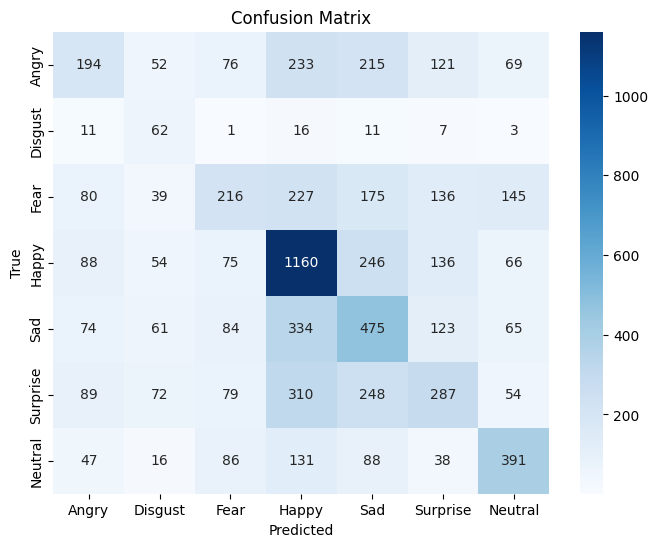

              precision    recall  f1-score   support

       Angry       0.33      0.20      0.25       960
     Disgust       0.17      0.56      0.27       111
        Fear       0.35      0.21      0.26      1018
       Happy       0.48      0.64      0.55      1825
         Sad       0.33      0.39      0.36      1216
    Surprise       0.34      0.25      0.29      1139
     Neutral       0.49      0.49      0.49       797

    accuracy                           0.39      7066
   macro avg       0.36      0.39      0.35      7066
weighted avg       0.39      0.39      0.38      7066



In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Skupljamo sve prave i predviđene vrednosti
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Konfuziona matrica
cm = confusion_matrix(y_true, y_pred)

# Ako imaš 7 emocija (npr. FER2013 dataset)
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 3. Izveštaj (preciznost, recall, F1 po klasi)
print(classification_report(y_true, y_pred, target_names=class_names))


In [33]:
from tensorflow.keras.optimizers import Adam

for layer in base_model.layers[-4:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[macro_f1, 'accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)


history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

# Evaluacija
loss, macro_f1, acc, prec, rec, auc = model.evaluate(test_ds)
print(f"Fine-tuned -> Macro F!: {macro_f1:.3f}, Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")

Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 93s 441ms/step - accuracy: 0.4785 - auc: 0.8316 - loss: 1.3838 - macro_f1: 0.4513 - precision: 0.7308 - recall: 0.2476 - val_accuracy: 0.4343 - val_auc: 0.7978 - val_loss: 1.5140 - val_macro_f1: 0.4044 - val_precision: 0.6579 - val_recall: 0.2229
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 58s 285ms/step - accuracy: 0.4940 - auc: 0.8431 - loss: 1.3342 - macro_f1: 0.4697 - precision: 0.7437 - recall: 0.2618 - val_accuracy: 0.4274 - val_auc: 0.7966 - val_loss: 1.5091 - val_macro_f1: 0.4171 - val_precision: 0.6892 - val_recall: 0.2074
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5028 - auc: 0.8519 - loss: 1.2991 - macro_f1: 0.4814 - precision: 0.7603 - recall: 0.2748

203/203 ━━━━━━━━━━━━━━━━━━━━ 57s 283ms/step - accuracy: 0.5039 - auc: 0.8487 - loss: 1.3119 - macro_f1: 0.4796 - precision: 0.7549 - recall: 0.2733 - val_accuracy: 0.4445 - val_auc: 0.8070 - val_loss: 1.4768 - val_macro_f1: 0.4258 - val_precision: 0.6794 - val_recall: 0.2204
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 63s 311ms/step - accuracy: 0.5162 - auc: 0.8561 - loss: 1.2831 - macro_f1: 0.4918 - precision: 0.7736 - recall: 0.2883 - val_accuracy: 0.4115 - val_auc: 0.7827 - val_loss: 1.5710 - val_macro_f1: 0.3986 - val_precision: 0.6343 - val_recall: 0.2147
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5163 - auc: 0.8581 - loss: 1.2772 - macro_f1: 0.4961 - precision: 0.7724 - recall: 0.2824

203/203 ━━━━━━━━━━━━━━━━━━━━ 56s 275ms/step - accuracy: 0.5165 - auc: 0.8570 - loss: 1.2790 - macro_f1: 0.4932 - precision: 0.7722 - recall: 0.2847 - val_accuracy: 0.4525 - val_auc: 0.8081 - val_loss: 1.4719 - val_macro_f1: 0.4213 - val_precision: 0.6711 - val_recall: 0.2519
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5216 - auc: 0.8602 - loss: 1.2638 - macro_f1: 0.4977 - precision: 0.7785 - recall: 0.2959

203/203 ━━━━━━━━━━━━━━━━━━━━ 54s 267ms/step - accuracy: 0.5196 - auc: 0.8604 - loss: 1.2638 - macro_f1: 0.4974 - precision: 0.7733 - recall: 0.2954 - val_accuracy: 0.4515 - val_auc: 0.8127 - val_loss: 1.4576 - val_macro_f1: 0.4210 - val_precision: 0.6739 - val_recall: 0.2644
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5349 - auc: 0.8681 - loss: 1.2340 - macro_f1: 0.5128 - precision: 0.7821 - recall: 0.3096

203/203 ━━━━━━━━━━━━━━━━━━━━ 66s 324ms/step - accuracy: 0.5334 - auc: 0.8662 - loss: 1.2400 - macro_f1: 0.5115 - precision: 0.7819 - recall: 0.3073 - val_accuracy: 0.4539 - val_auc: 0.8160 - val_loss: 1.4443 - val_macro_f1: 0.4348 - val_precision: 0.6933 - val_recall: 0.2477
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 104s 508ms/step - accuracy: 0.5372 - auc: 0.8696 - loss: 1.2262 - macro_f1: 0.5167 - precision: 0.7866 - recall: 0.3139 - val_accuracy: 0.4601 - val_auc: 0.8160 - val_loss: 1.4511 - val_macro_f1: 0.4341 - val_precision: 0.6696 - val_recall: 0.2687
Epoch 9/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 57s 282ms/step - accuracy: 0.5440 - auc: 0.8726 - loss: 1.2133 - macro_f1: 0.5240 - precision: 0.7920 - recall: 0.3233 - val_accuracy: 0.4561 - val_auc: 0.8154 - val_loss: 1.4604 - val_macro_f1: 0.4305 - val_precision: 0.6661 - val_recall: 0.2602
Epoch 10/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 58s 285ms/step - accuracy: 0.5460 - auc: 0.8742 - loss: 1.2060 - macro_f1: 0.5245 - precision: 0.7903 - reca

203/203 ━━━━━━━━━━━━━━━━━━━━ 59s 289ms/step - accuracy: 0.5531 - auc: 0.8776 - loss: 1.1903 - macro_f1: 0.5337 - precision: 0.7938 - recall: 0.3334 - val_accuracy: 0.4592 - val_auc: 0.8193 - val_loss: 1.4401 - val_macro_f1: 0.4369 - val_precision: 0.6795 - val_recall: 0.2804
Epoch 13/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 59s 288ms/step - accuracy: 0.5623 - auc: 0.8823 - loss: 1.1686 - macro_f1: 0.5439 - precision: 0.8061 - recall: 0.3443 - val_accuracy: 0.4532 - val_auc: 0.8156 - val_loss: 1.4570 - val_macro_f1: 0.4356 - val_precision: 0.6874 - val_recall: 0.2684
Epoch 14/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.5633 - auc: 0.8844 - loss: 1.1584 - macro_f1: 0.5440 - precision: 0.8077 - recall: 0.3538 - val_accuracy: 0.4586 - val_auc: 0.8182 - val_loss: 1.4478 - val_macro_f1: 0.4267 - val_precision: 0.6712 - val_recall: 0.2971
Epoch 15/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 58s 287ms/step - accuracy: 0.5698 - auc: 0.8868 - loss: 1.1483 - macro_f1: 0.5531 - precision: 0.8092 - rec

203/203 ━━━━━━━━━━━━━━━━━━━━ 62s 304ms/step - accuracy: 0.5711 - auc: 0.8873 - loss: 1.1461 - macro_f1: 0.5519 - precision: 0.8037 - recall: 0.3583 - val_accuracy: 0.4692 - val_auc: 0.8230 - val_loss: 1.4320 - val_macro_f1: 0.4466 - val_precision: 0.6824 - val_recall: 0.2899
Epoch 17/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 61s 301ms/step - accuracy: 0.5747 - auc: 0.8901 - loss: 1.1336 - macro_f1: 0.5571 - precision: 0.8127 - recall: 0.3657 - val_accuracy: 0.4589 - val_auc: 0.8175 - val_loss: 1.4762 - val_macro_f1: 0.4315 - val_precision: 0.6323 - val_recall: 0.3090
Epoch 18/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.5748 - auc: 0.8908 - loss: 1.1290 - macro_f1: 0.5552 - precision: 0.8097 - recall: 0.3676

203/203 ━━━━━━━━━━━━━━━━━━━━ 62s 307ms/step - accuracy: 0.5772 - auc: 0.8912 - loss: 1.1267 - macro_f1: 0.5614 - precision: 0.8137 - recall: 0.3654 - val_accuracy: 0.4737 - val_auc: 0.8253 - val_loss: 1.4211 - val_macro_f1: 0.4540 - val_precision: 0.6871 - val_recall: 0.2905
Epoch 19/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 61s 300ms/step - accuracy: 0.5835 - auc: 0.8950 - loss: 1.1093 - macro_f1: 0.5682 - precision: 0.8221 - recall: 0.3757 - val_accuracy: 0.4643 - val_auc: 0.8202 - val_loss: 1.4593 - val_macro_f1: 0.4326 - val_precision: 0.6391 - val_recall: 0.3081
Epoch 20/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 62s 306ms/step - accuracy: 0.5879 - auc: 0.8972 - loss: 1.0992 - macro_f1: 0.5728 - precision: 0.8221 - recall: 0.3840 - val_accuracy: 0.4711 - val_auc: 0.8248 - val_loss: 1.4302 - val_macro_f1: 0.4576 - val_precision: 0.6760 - val_recall: 0.2825
Epoch 21/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 68s 333ms/step - accuracy: 0.5910 - auc: 0.8986 - loss: 1.0924 - macro_f1: 0.5747 - precision: 0.8292 - rec

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━

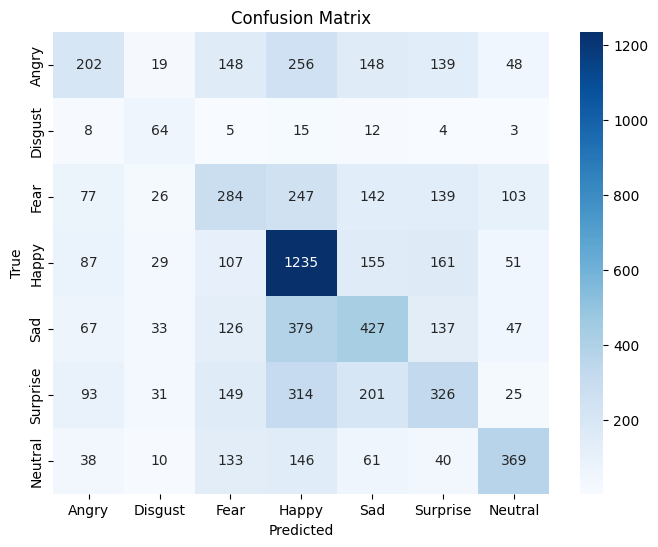

              precision    recall  f1-score   support

       Angry       0.35      0.21      0.26       960
     Disgust       0.30      0.58      0.40       111
        Fear       0.30      0.28      0.29      1018
       Happy       0.48      0.68      0.56      1825
         Sad       0.37      0.35      0.36      1216
    Surprise       0.34      0.29      0.31      1139
     Neutral       0.57      0.46      0.51       797

    accuracy                           0.41      7066
   macro avg       0.39      0.41      0.38      7066
weighted avg       0.40      0.41      0.40      7066



In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Skupljamo sve prave i predviđene vrednosti
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Konfuziona matrica
cm = confusion_matrix(y_true, y_pred)

# Ako imaš 7 emocija (npr. FER2013 dataset)
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 3. Izveštaj (preciznost, recall, F1 po klasi)
print(classification_report(y_true, y_pred, target_names=class_names))


<h1 style="color: #16537e">MOBILENET V2</h1>

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    # tf.keras.layers.RandomZoom(0.1),
    # tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Base model bez top sloja
base_model = MobileNetV2(
    input_shape=(48,48,3),
    include_top=False,     # ukloni Dense sloj za klasifikaciju
    weights='imagenet'     # pretrained težine
)

for layer in base_model.layers:
    layer.trainable = False

inputs = layers.Input(shape=(48,48,3))
x = data_augmentation(inputs)    
x = base_model(x, training=False)      
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[macro_f1, 'accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

#Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)


loss, f1, acc, prec, rec, auc = model.evaluate(test_ds_rgb)
print(f"Macro F1: {f1:.3f}, Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")


C:\Users\Skynet\AppData\Local\Temp\ipykernel_13540\4198607637.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2753 - auc: 0.6522 - loss: 1.8705 - macro_f1: 0.2323 - precision: 0.4182 - recall: 0.0416

203/203 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3050 - auc: 0.6867 - loss: 1.7791 - macro_f1: 0.2646 - precision: 0.5088 - recall: 0.0481 - val_accuracy: 0.3314 - val_auc: 0.7174 - val_loss: 1.7205 - val_macro_f1: 0.2788 - val_precision: 0.5421 - val_recall: 0.0985
Epoch 2/50
201/203 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3422 - auc: 0.7312 - loss: 1.6809 - macro_f1: 0.3033 - precision: 0.6157 - recall: 0.0804

203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.3506 - auc: 0.7368 - loss: 1.6665 - macro_f1: 0.3139 - precision: 0.6266 - recall: 0.0882 - val_accuracy: 0.3451 - val_auc: 0.7323 - val_loss: 1.7064 - val_macro_f1: 0.2973 - val_precision: 0.5148 - val_recall: 0.1258
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3718 - auc: 0.7517 - loss: 1.6275 - macro_f1: 0.3376 - precision: 0.6364 - recall: 0.1034

203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.3748 - auc: 0.7538 - loss: 1.6216 - macro_f1: 0.3399 - precision: 0.6395 - recall: 0.1077 - val_accuracy: 0.3590 - val_auc: 0.7430 - val_loss: 1.6523 - val_macro_f1: 0.3294 - val_precision: 0.6164 - val_recall: 0.1054
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3848 - auc: 0.7623 - loss: 1.5981 - macro_f1: 0.3522 - precision: 0.6631 - recall: 0.1207

203/203 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3857 - auc: 0.7646 - loss: 1.5912 - macro_f1: 0.3524 - precision: 0.6659 - recall: 0.1243 - val_accuracy: 0.3792 - val_auc: 0.7537 - val_loss: 1.6365 - val_macro_f1: 0.3432 - val_precision: 0.5567 - val_recall: 0.1471
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.3975 - auc: 0.7767 - loss: 1.5568 - macro_f1: 0.3664 - precision: 0.6675 - recall: 0.1434 - val_accuracy: 0.3746 - val_auc: 0.7511 - val_loss: 1.6393 - val_macro_f1: 0.3509 - val_precision: 0.5902 - val_recall: 0.1283
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4091 - auc: 0.7837 - loss: 1.5362 - macro_f1: 0.3781 - precision: 0.6836 - recall: 0.1545

203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.4094 - auc: 0.7839 - loss: 1.5355 - macro_f1: 0.3790 - precision: 0.6776 - recall: 0.1566 - val_accuracy: 0.3829 - val_auc: 0.7658 - val_loss: 1.5995 - val_macro_f1: 0.3523 - val_precision: 0.6024 - val_recall: 0.1625
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4210 - auc: 0.7911 - loss: 1.5129 - macro_f1: 0.3915 - precision: 0.6998 - recall: 0.1638

203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.4209 - auc: 0.7910 - loss: 1.5130 - macro_f1: 0.3910 - precision: 0.6927 - recall: 0.1653 - val_accuracy: 0.3896 - val_auc: 0.7645 - val_loss: 1.5983 - val_macro_f1: 0.3708 - val_precision: 0.6107 - val_recall: 0.1422
Epoch 8/50
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4189 - auc: 0.7965 - loss: 1.4970 - macro_f1: 0.3931 - precision: 0.6888 - recall: 0.1661

203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4222 - auc: 0.7970 - loss: 1.4958 - macro_f1: 0.3932 - precision: 0.6911 - recall: 0.1716 - val_accuracy: 0.3951 - val_auc: 0.7739 - val_loss: 1.5714 - val_macro_f1: 0.3661 - val_precision: 0.6270 - val_recall: 0.1821
Epoch 9/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4313 - auc: 0.8010 - loss: 1.4813 - macro_f1: 0.4055 - precision: 0.7033 - recall: 0.1832 - val_accuracy: 0.3973 - val_auc: 0.7735 - val_loss: 1.5775 - val_macro_f1: 0.3625 - val_precision: 0.6007 - val_recall: 0.1855
Epoch 10/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.4398 - auc: 0.8080 - loss: 1.4579 - macro_f1: 0.4121 - precision: 0.7159 - recall: 0.1960 - val_accuracy: 0.3999 - val_auc: 0.7759 - val_loss: 1.5731 - val_macro_f1: 0.3730 - val_precision: 0.6047 - val_recall: 0.1868
Epoch 11/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4457 - auc: 0.8126 - loss: 1.4440 - macro_f1: 0.4217 - precision: 0.7150 - recall: 0.20

203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4506 - auc: 0.8130 - loss: 1.4423 - macro_f1: 0.4254 - precision: 0.7118 - recall: 0.2048 - val_accuracy: 0.4045 - val_auc: 0.7790 - val_loss: 1.5625 - val_macro_f1: 0.3892 - val_precision: 0.6502 - val_recall: 0.1764
Epoch 12/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4600 - auc: 0.8194 - loss: 1.4194 - macro_f1: 0.4382 - precision: 0.7256 - recall: 0.2131

203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.4546 - auc: 0.8170 - loss: 1.4268 - macro_f1: 0.4304 - precision: 0.7259 - recall: 0.2137 - val_accuracy: 0.4153 - val_auc: 0.7815 - val_loss: 1.5581 - val_macro_f1: 0.3904 - val_precision: 0.6252 - val_recall: 0.1954
Epoch 13/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4591 - auc: 0.8213 - loss: 1.4110 - macro_f1: 0.4340 - precision: 0.7162 - recall: 0.2205

203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4578 - auc: 0.8197 - loss: 1.4168 - macro_f1: 0.4331 - precision: 0.7134 - recall: 0.2179 - val_accuracy: 0.4089 - val_auc: 0.7821 - val_loss: 1.5536 - val_macro_f1: 0.3809 - val_precision: 0.6206 - val_recall: 0.2010
Epoch 14/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4563 - auc: 0.8216 - loss: 1.4117 - macro_f1: 0.4333 - precision: 0.7210 - recall: 0.2195

203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4595 - auc: 0.8218 - loss: 1.4095 - macro_f1: 0.4347 - precision: 0.7167 - recall: 0.2221 - val_accuracy: 0.4047 - val_auc: 0.7813 - val_loss: 1.5451 - val_macro_f1: 0.3900 - val_precision: 0.6527 - val_recall: 0.1857
Epoch 15/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4664 - auc: 0.8258 - loss: 1.3951 - macro_f1: 0.4449 - precision: 0.7254 - recall: 0.2272 - val_accuracy: 0.4095 - val_auc: 0.7793 - val_loss: 1.5757 - val_macro_f1: 0.3814 - val_precision: 0.5997 - val_recall: 0.2164
Epoch 16/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.4651 - auc: 0.8291 - loss: 1.3854 - macro_f1: 0.4419 - precision: 0.7168 - recall: 0.2331 - val_accuracy: 0.4050 - val_auc: 0.7777 - val_loss: 1.5800 - val_macro_f1: 0.3831 - val_precision: 0.5997 - val_recall: 0.1991
Epoch 17/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4734 - auc: 0.8323 - loss: 1.3736 - macro_f1: 0.4542 - precision: 0.7225 - recall: 0.

203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4731 - auc: 0.8316 - loss: 1.3762 - macro_f1: 0.4514 - precision: 0.7203 - recall: 0.2381 - val_accuracy: 0.4207 - val_auc: 0.7905 - val_loss: 1.5219 - val_macro_f1: 0.3926 - val_precision: 0.6455 - val_recall: 0.2054
Epoch 18/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4749 - auc: 0.8343 - loss: 1.3625 - macro_f1: 0.4524 - precision: 0.7302 - recall: 0.2475 - val_accuracy: 0.4218 - val_auc: 0.7899 - val_loss: 1.5405 - val_macro_f1: 0.4011 - val_precision: 0.6042 - val_recall: 0.2224
Epoch 19/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4804 - auc: 0.8357 - loss: 1.3602 - macro_f1: 0.4638 - precision: 0.7243 - recall: 0.2469

203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4819 - auc: 0.8365 - loss: 1.3566 - macro_f1: 0.4615 - precision: 0.7266 - recall: 0.2507 - val_accuracy: 0.4211 - val_auc: 0.7925 - val_loss: 1.5175 - val_macro_f1: 0.4048 - val_precision: 0.6425 - val_recall: 0.2067
Epoch 20/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4791 - auc: 0.8371 - loss: 1.3526 - macro_f1: 0.4581 - precision: 0.7334 - recall: 0.2528 - val_accuracy: 0.4183 - val_auc: 0.7868 - val_loss: 1.5556 - val_macro_f1: 0.4043 - val_precision: 0.6124 - val_recall: 0.2187
Epoch 21/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4834 - auc: 0.8415 - loss: 1.3370 - macro_f1: 0.4638 - precision: 0.7268 - recall: 0.2612

203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.4836 - auc: 0.8402 - loss: 1.3413 - macro_f1: 0.4650 - precision: 0.7325 - recall: 0.2572 - val_accuracy: 0.4328 - val_auc: 0.7962 - val_loss: 1.5174 - val_macro_f1: 0.4028 - val_precision: 0.6190 - val_recall: 0.2349
Epoch 22/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4848 - auc: 0.8409 - loss: 1.3384 - macro_f1: 0.4655 - precision: 0.7401 - recall: 0.2624 - val_accuracy: 0.4288 - val_auc: 0.7941 - val_loss: 1.5291 - val_macro_f1: 0.4030 - val_precision: 0.6041 - val_recall: 0.2365
Epoch 23/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4893 - auc: 0.8431 - loss: 1.3305 - macro_f1: 0.4694 - precision: 0.7418 - recall: 0.2648 - val_accuracy: 0.4280 - val_auc: 0.7920 - val_loss: 1.5391 - val_macro_f1: 0.4054 - val_precision: 0.6094 - val_recall: 0.2446
Epoch 24/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.4974 - auc: 0.8455 - loss: 1.3216 - macro_f1: 0.4796 - precision: 0.7353 - recall: 0.2

In [18]:
data_augmentation.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (48, 48, 1)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (48, 48, 1)            │             0 │
│ (RandomRotation)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
set_trainable = False
for layer in base_model.layers:
    if layer.name.startswith("block_16"):
        set_trainable = True
    if set_trainable:
        # BatchNorm ostaje zamrznut
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

history_finetune = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

loss, acc, prec, rec, auc = model.evaluate(test_ds_rgb)
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")

Epoch 1/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.4971 - auc: 0.8471 - loss: 1.3151 - precision: 0.7359 - recall: 0.2728 - val_accuracy: 0.4223 - val_auc: 0.7922 - val_loss: 1.5312 - val_precision: 0.6119 - val_recall: 0.2261
Epoch 2/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.5003 - auc: 0.8495 - loss: 1.3038 - precision: 0.7458 - recall: 0.2807 - val_accuracy: 0.4238 - val_auc: 0.7936 - val_loss: 1.5401 - val_precision: 0.5934 - val_recall: 0.2442
Epoch 3/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.5081 - auc: 0.8533 - loss: 1.2904 - precision: 0.7461 - recall: 0.2880 - val_accuracy: 0.4280 - val_auc: 0.7945 - val_loss: 1.5286 - val_precision: 0.6110 - val_recall: 0.2366
Epoch 4/15
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5072 - auc: 0.8549 - loss: 1.2832 - precision: 0.7475 - recall: 0.2943

203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.5096 - auc: 0.8555 - loss: 1.2810 - precision: 0.7417 - recall: 0.2945 - val_accuracy: 0.4285 - val_auc: 0.8001 - val_loss: 1.5149 - val_precision: 0.6147 - val_recall: 0.2556
Epoch 5/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.5129 - auc: 0.8571 - loss: 1.2748 - precision: 0.7490 - recall: 0.2950 - val_accuracy: 0.4328 - val_auc: 0.7976 - val_loss: 1.5185 - val_precision: 0.6227 - val_recall: 0.2448
Epoch 6/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.5125 - auc: 0.8565 - loss: 1.2779 - precision: 0.7439 - recall: 0.2922 - val_accuracy: 0.4305 - val_auc: 0.7984 - val_loss: 1.5184 - val_precision: 0.6100 - val_recall: 0.2474
Epoch 7/15
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5202 - auc: 0.8606 - loss: 1.2601 - precision: 0.7569 - recall: 0.3025

203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.5178 - auc: 0.8584 - loss: 1.2691 - precision: 0.7456 - recall: 0.3000 - val_accuracy: 0.4265 - val_auc: 0.7998 - val_loss: 1.5137 - val_precision: 0.6080 - val_recall: 0.2533
Epoch 8/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.5155 - auc: 0.8591 - loss: 1.2653 - precision: 0.7467 - recall: 0.3011 - val_accuracy: 0.4265 - val_auc: 0.7984 - val_loss: 1.5231 - val_precision: 0.6106 - val_recall: 0.2517
Epoch 9/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.5204 - auc: 0.8620 - loss: 1.2540 - precision: 0.7456 - recall: 0.3068 - val_accuracy: 0.4257 - val_auc: 0.7986 - val_loss: 1.5162 - val_precision: 0.6162 - val_recall: 0.2463
Epoch 10/15
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5197 - auc: 0.8608 - loss: 1.2572 - precision: 0.7586 - recall: 0.3136

203/203 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.5182 - auc: 0.8600 - loss: 1.2612 - precision: 0.7562 - recall: 0.3089 - val_accuracy: 0.4353 - val_auc: 0.8013 - val_loss: 1.5040 - val_precision: 0.6303 - val_recall: 0.2471
Epoch 11/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.5216 - auc: 0.8623 - loss: 1.2530 - precision: 0.7536 - recall: 0.3057 - val_accuracy: 0.4357 - val_auc: 0.8008 - val_loss: 1.5135 - val_precision: 0.6088 - val_recall: 0.2517
Epoch 12/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.5209 - auc: 0.8639 - loss: 1.2456 - precision: 0.7535 - recall: 0.3123 - val_accuracy: 0.4354 - val_auc: 0.7984 - val_loss: 1.5233 - val_precision: 0.6118 - val_recall: 0.2471
Epoch 13/15
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5297 - auc: 0.8650 - loss: 1.2443 - precision: 0.7511 - recall: 0.3121

203/203 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.5255 - auc: 0.8642 - loss: 1.2459 - precision: 0.7496 - recall: 0.3110 - val_accuracy: 0.4419 - val_auc: 0.8036 - val_loss: 1.4999 - val_precision: 0.6152 - val_recall: 0.2517
Epoch 14/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.5226 - auc: 0.8633 - loss: 1.2472 - precision: 0.7494 - recall: 0.3124 - val_accuracy: 0.4345 - val_auc: 0.8027 - val_loss: 1.5152 - val_precision: 0.6043 - val_recall: 0.2675
Epoch 15/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.5237 - auc: 0.8658 - loss: 1.2386 - precision: 0.7499 - recall: 0.3160 - val_accuracy: 0.4407 - val_auc: 0.8037 - val_loss: 1.5053 - val_precision: 0.6196 - val_recall: 0.2635
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3999 - auc: 0.7829 - loss: 1.5900 - precision: 0.5527 - recall: 0.2219
Accuracy: 0.400, Precision: 0.553, Recall: 0.222, AUC: 0.783


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━

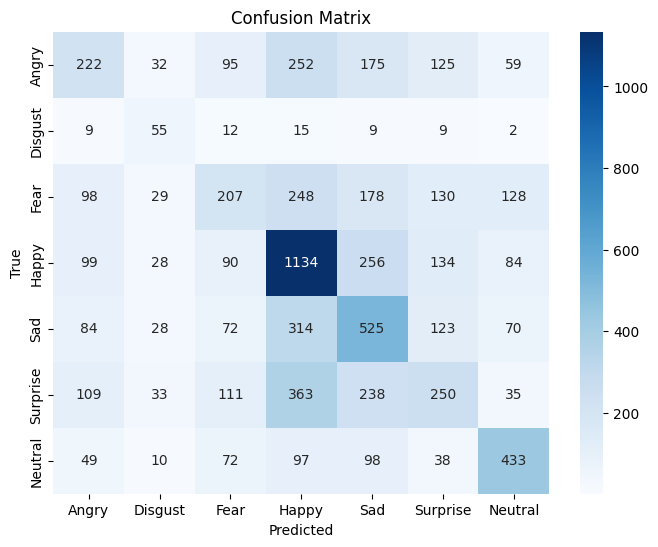

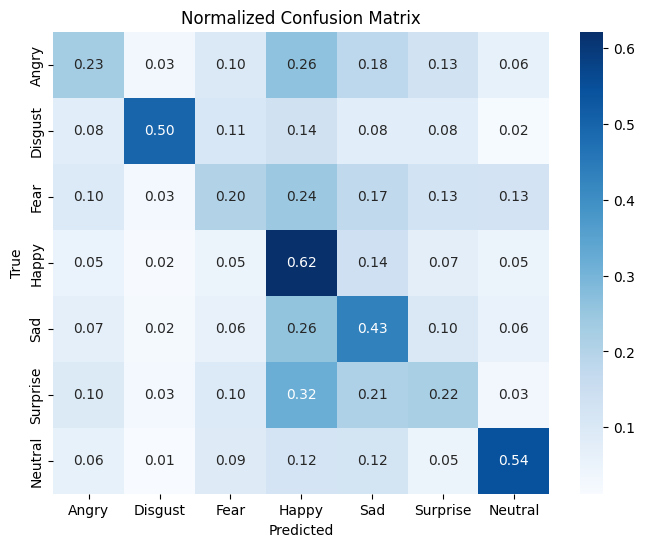

              precision    recall  f1-score   support

       Angry       0.33      0.23      0.27       960
     Disgust       0.26      0.50      0.34       111
        Fear       0.31      0.20      0.25      1018
       Happy       0.47      0.62      0.53      1825
         Sad       0.35      0.43      0.39      1216
    Surprise       0.31      0.22      0.26      1139
     Neutral       0.53      0.54      0.54       797

    accuracy                           0.40      7066
   macro avg       0.37      0.39      0.37      7066
weighted avg       0.39      0.40      0.38      7066



In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Skupljamo sve prave i predviđene vrednosti
y_true = []
y_pred = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Konfuziona matrica
cm = confusion_matrix(y_true, y_pred)

# Ako imaš 7 emocija (npr. FER2013 dataset)
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()
_

# 3. Izveštaj (preciznost, recall, F1 po klasi)
print(classification_report(y_true, y_pred, target_names=class_names))


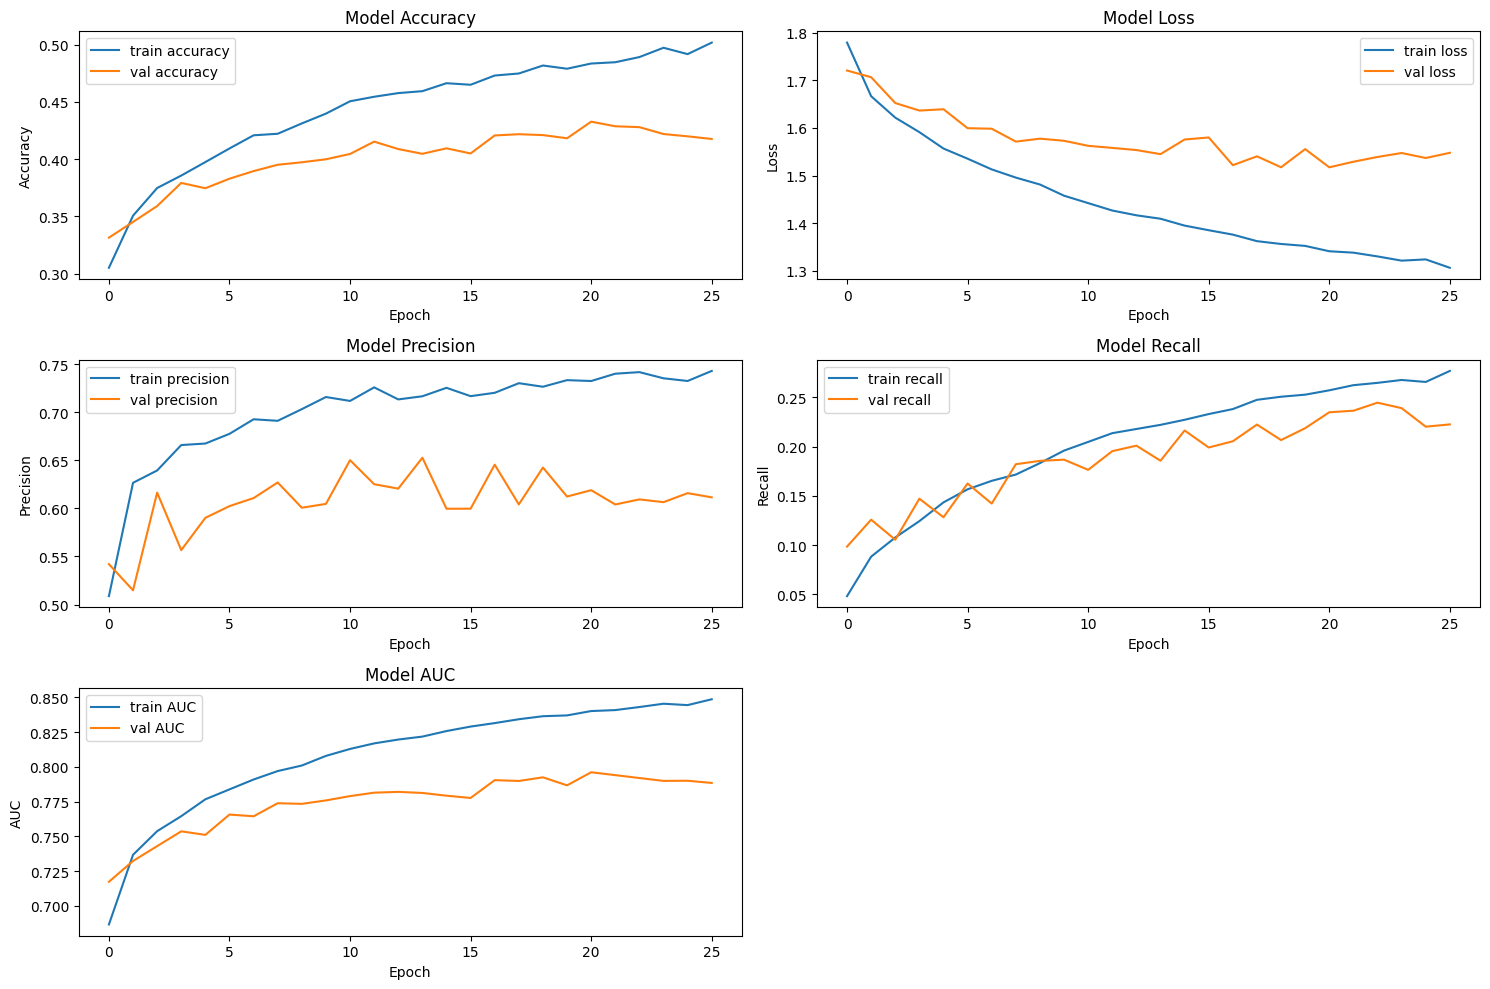

In [22]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()

<h1 style="color: #16537e">BASELINE CNN</h1>

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Parametri
img_height = 48
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 1e-4

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

# Build baseline CNN
inputs = layers.Input(shape=(img_height, img_width, 3))  
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'),
             metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_baseline_cnn.keras', monitor='val_loss', save_best_only=True)

# Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=50,
    callbacks=[early_stop, model_checkpoint]
)

# Evaluate
best_model = tf.keras.models.load_model('best_baseline_cnn.keras')
eval_results = best_model.evaluate(test_ds_rgb)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.2306 - auc: 0.5997 - loss: 1.9112 - precision: 0.2847 - recall: 0.0017 - val_accuracy: 0.2516 - val_auc: 0.6654 - val_loss: 1.8935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.3106 - auc: 0.6843 - loss: 1.7952 - precision: 0.5023 - recall: 0.0047 - val_accuracy: 0.3026 - val_auc: 0.7042 - val_loss: 1.8254 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3526 - auc: 0.7255 - loss: 1.7087 - precision: 0.6667 - recall: 0.0352 - val_accuracy: 0.3584 - val_auc: 0.7444 - val_loss: 1.7083 - val_precision: 0.8235 - val_recall: 0.0024
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3743 - auc: 0.7527 - loss: 1.6406 - precision: 0.7025 - recall: 0.0762 - val_accuracy: 0.3999 - val_auc: 0.7629 - val_loss: 1.6137 - val_precision: 0.8173 - val_recall: 0.0605
Epoch 5/50
1

In [62]:
def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

rare_class_repeat = {
    'fear': 2,
    'surprise': 2,
    'angry': 1,
    'disgust': 1
}

train_ds_balanced = train_ds.unbatch() 

for rare_class, repeat_num in rare_class_repeat.items():
    rare_idx = train_class_names.index(rare_class)
    rare_ds = train_ds_balanced.filter(lambda x, y: tf.argmax(y) == rare_idx)
    common_ds = train_ds_balanced.filter(lambda x, y: tf.argmax(y) != rare_idx)
    rare_ds_aug = rare_ds.map(augment,  num_parallel_calls=tf.data.AUTOTUNE).repeat(repeat_num)
    train_ds_balanced = common_ds.concatenate(rare_ds_aug)

train_ds_balanced = train_ds_balanced.batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)


count = sum(images.shape[0] for images, labels in train_ds_balanced)
val_count = sum(images.shape[0] for images, labels in val_ds)
test_count = sum(images.shape[0] for images, labels in test_ds)

print("Train:", count, "Validation:", val_count, "Test:", test_count)


Train: 31752 Validation: 6479 Test: 7066


In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Parametri
img_height = 48
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 1e-4

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    # layers.RandomZoom(0.1),
])

# Build baseline CNN
inputs = layers.Input(shape=(img_height, img_width, 1))  
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'),
             metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_baseline_cnn.keras', monitor='val_loss', save_best_only=True)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, model_checkpoint]
)

# Evaluate
best_model = tf.keras.models.load_model('best_baseline_cnn.keras')
eval_results = best_model.evaluate(test_ds)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.1845 - auc: 0.5614 - loss: 1.9675 - precision: 0.1704 - recall: 0.0020 - val_accuracy: 0.2247 - val_auc: 0.6135 - val_loss: 1.9220 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2488 - auc: 0.6320 - loss: 1.8643 - precision: 0.3889 - recall: 2.7021e-04 - val_accuracy: 0.2755 - val_auc: 0.6675 - val_loss: 1.8751 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.2877 - auc: 0.6676 - loss: 1.8123 - precision: 0.5330 - recall: 0.0041 - val_accuracy: 0.3164 - val_auc: 0.7010 - val_loss: 1.7632 - val_precision: 0.8889 - val_recall: 0.0012
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.3257 - auc: 0.6996 - loss: 1.7524 - precision: 0.6214 - recall: 0.0226 - val_accuracy: 0.3760 - val_auc: 0.7454 - val_loss: 1.6687 - val_precision: 0.8375 - val_recall: 0.0207
Epo

Baseline RGB - everything else is exacly the same

Train sample:


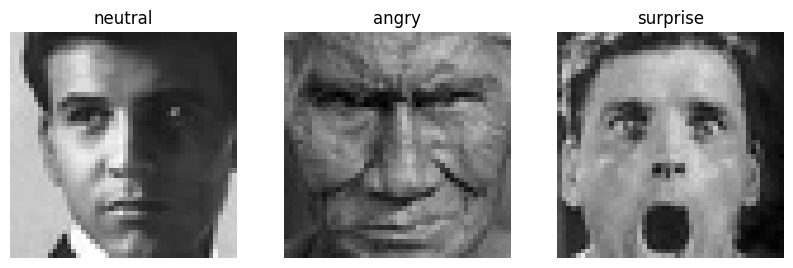

Validation sample:


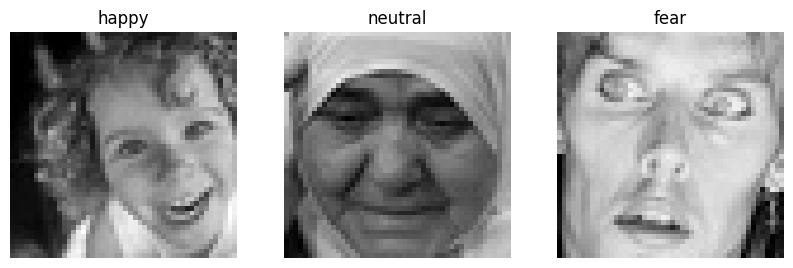

Test sample:


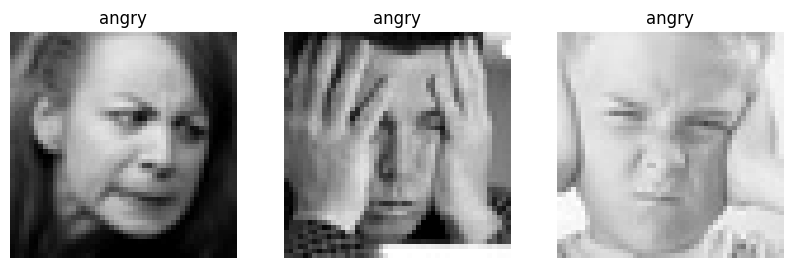

In [6]:
import tensorflow as tf

def grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds_rgb = train_ds.map(grayscale_to_rgb)
val_ds_rgb = val_ds.map(grayscale_to_rgb)
test_ds_rgb = test_ds.map(grayscale_to_rgb)


import matplotlib.pyplot as plt

def show_images(dataset, class_names, n=3):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy().argmax()])
            plt.axis("off")
    plt.show()

print("Train sample:")
show_images(train_ds_rgb, class_names)

print("Validation sample:")
show_images(val_ds_rgb, class_names)

print("Test sample:")
show_images(test_ds_rgb, class_names)


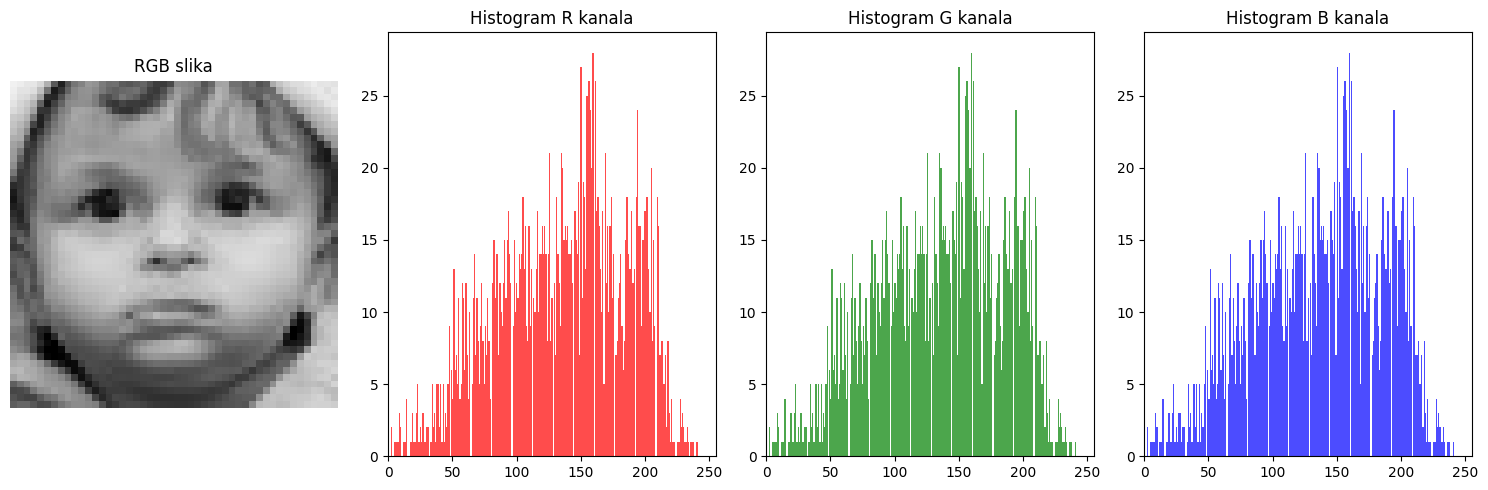

In [7]:
import matplotlib.pyplot as plt

# Uzmi jednu sliku iz train_ds_rgb
for images, labels in train_ds_rgb.take(1):
    image = images[0].numpy().astype("uint8")  # prva slika
    break

plt.figure(figsize=(15,5))

# Prikaži sliku
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("RGB slika")
plt.axis("off")

# Histogram za svaki kanal
colors = ("r", "g", "b")
for i, col in enumerate(colors):
    plt.subplot(1, 4, i+2)
    plt.hist(image[:, :, i].ravel(), bins=256, color=col, alpha=0.7)
    plt.title(f"Histogram {col.upper()} kanala")
    plt.xlim([0, 255])

plt.tight_layout()
plt.show()


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds_rgb = train_ds_rgb.map(lambda x, y: (normalization_layer(x), y))
val_ds_rgb = val_ds_rgb.map(lambda x, y: (normalization_layer(x), y))
test_ds_rgb = test_ds_rgb.map(lambda x, y: (normalization_layer(x), y))

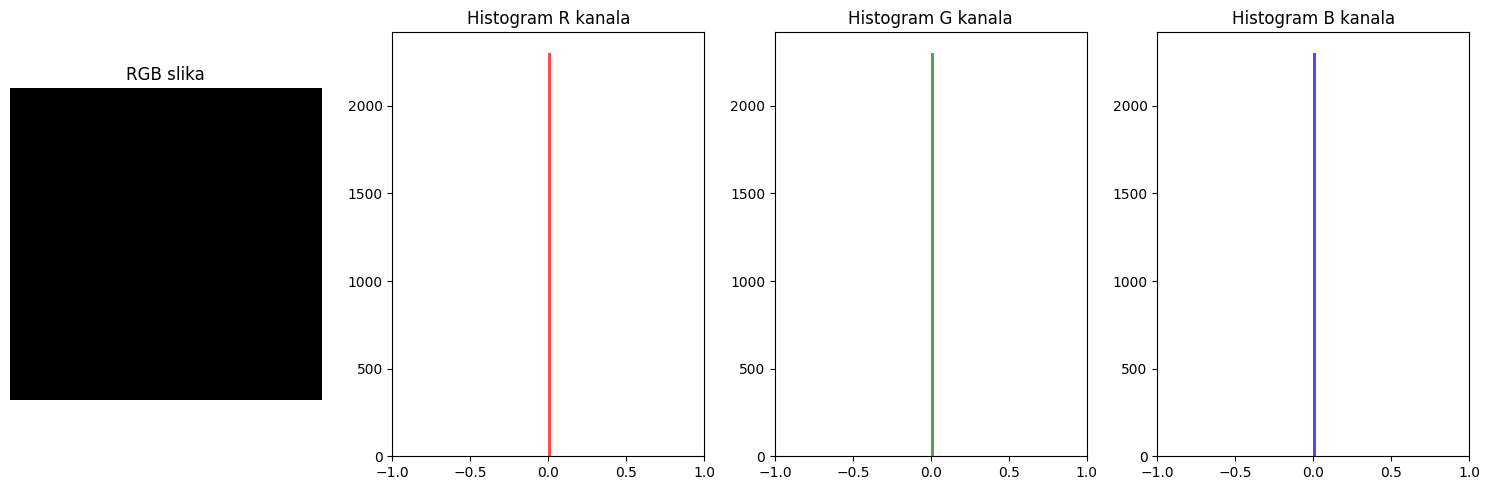

R=G?  True
R=B?  True
G=B?  True


In [9]:
import matplotlib.pyplot as plt

# Uzmi jednu sliku iz train_ds_rgb
for images, labels in train_ds_rgb.take(1):
    image = images[0].numpy().astype("uint8")  # prva slika
    break

plt.figure(figsize=(15,5))

# Prikaži sliku
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("RGB slika")
plt.axis("off")

# Histogram za svaki kanal
colors = ("r", "g", "b")
for i, col in enumerate(colors):
    plt.subplot(1, 4, i+2)
    plt.hist(image[:, :, i].ravel(), bins=50, color=col, alpha=0.7)
    plt.title(f"Histogram {col.upper()} kanala")
    plt.xlim([-1, 1])

plt.tight_layout()
plt.show()

#Assert
print("R=G? ", np.allclose(image[:,:,0], image[:,:,1]))
print("R=B? ", np.allclose(image[:,:,0], image[:,:,2]))
print("G=B? ", np.allclose(image[:,:,1], image[:,:,2]))


In [14]:
def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label


rare_class_repeat = {
    'fear': 2,
    'surprise': 2,
    'angry': 1,
    'disgust': 1
}

train_ds_balanced = train_ds.unbatch() 

for rare_class, repeat_num in rare_class_repeat.items():
    rare_idx = train_class_names.index(rare_class)
    rare_ds = train_ds_balanced.filter(lambda x, y: tf.argmax(y) == rare_idx)
    common_ds = train_ds_balanced.filter(lambda x, y: tf.argmax(y) != rare_idx)
    rare_ds_aug = rare_ds.map(augment,  num_parallel_calls=tf.data.AUTOTUNE).repeat(repeat_num)
    train_ds_balanced = common_ds.concatenate(rare_ds_aug)

train_ds_balanced = train_ds_balanced.batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)


count = sum(images.shape[0] for images, labels in train_ds_balanced)
val_count = sum(images.shape[0] for images, labels in val_ds)
test_count = sum(images.shape[0] for images, labels in test_ds)

print("Train:", count, "Validation:", val_count, "Test:", test_count)

Train: 31752 Validation: 6479 Test: 7066


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Parametri
img_height = 48
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 1e-4

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    # layers.RandomZoom(0.1),
])

# Build baseline CNN
inputs = layers.Input(shape=(img_height, img_width, 3))  
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'),
             metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_baseline_cnn.keras', monitor='val_loss', save_best_only=True)

# Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=100,
    callbacks=[early_stop, model_checkpoint]
)

# Evaluate
best_model = tf.keras.models.load_model('best_baseline_cnn.keras')
eval_results = best_model.evaluate(test_ds_rgb)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.1852 - auc: 0.5524 - loss: 2.0814 - precision: 0.1715 - recall: 0.0119 - val_accuracy: 0.2269 - val_auc: 0.6075 - val_loss: 1.9133 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.2655 - auc: 0.6427 - loss: 1.8485 - precision: 0.5647 - recall: 0.0037 - val_accuracy: 0.2973 - val_auc: 0.6822 - val_loss: 1.8575 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.2999 - auc: 0.6768 - loss: 1.7926 - precision: 0.6014 - recall: 0.0167 - val_accuracy: 0.3497 - val_auc: 0.7260 - val_loss: 1.7435 - val_precision: 0.6970 - val_recall: 0.0035
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3264 - auc: 0.7036 - loss: 1.7408 - precision: 0.6430 - recall: 0.0430 - val_accuracy: 0.3590 - val_auc: 0.7424 - val_loss: 1.6617 - val_precision: 0.7672 - val_recall: 0.0671
Epoch 5

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━

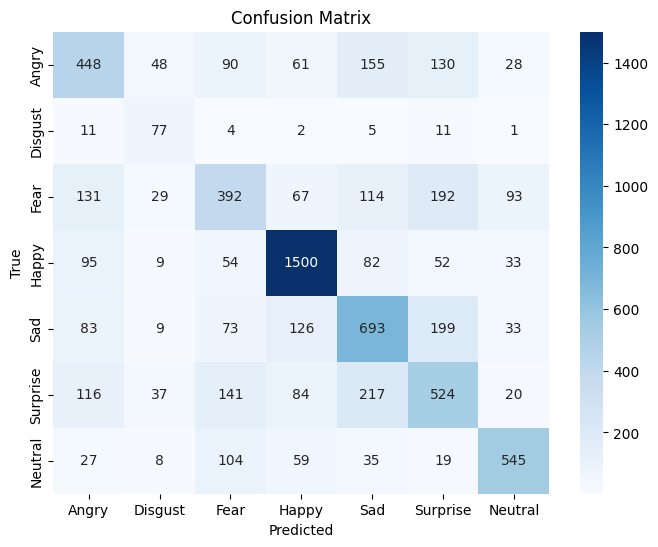

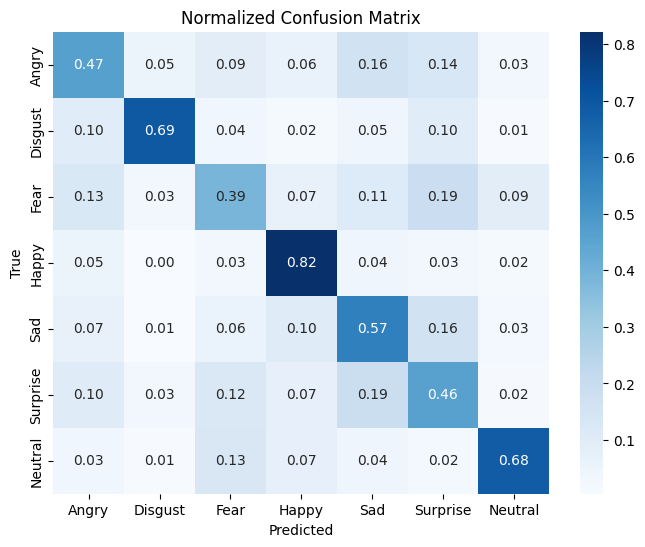

              precision    recall  f1-score   support

       Angry       0.49      0.47      0.48       960
     Disgust       0.35      0.69      0.47       111
        Fear       0.46      0.39      0.42      1018
       Happy       0.79      0.82      0.81      1825
         Sad       0.53      0.57      0.55      1216
    Surprise       0.46      0.46      0.46      1139
     Neutral       0.72      0.68      0.70       797

    accuracy                           0.59      7066
   macro avg       0.54      0.58      0.56      7066
weighted avg       0.59      0.59      0.59      7066



In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Skupljamo sve prave i predviđene vrednosti
y_true = []
y_pred = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Konfuziona matrica
cm = confusion_matrix(y_true, y_pred)

# Ako imaš 7 emocija (npr. FER2013 dataset)
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()
_

# 3. Izveštaj (preciznost, recall, F1 po klasi)
print(classification_report(y_true, y_pred, target_names=class_names))


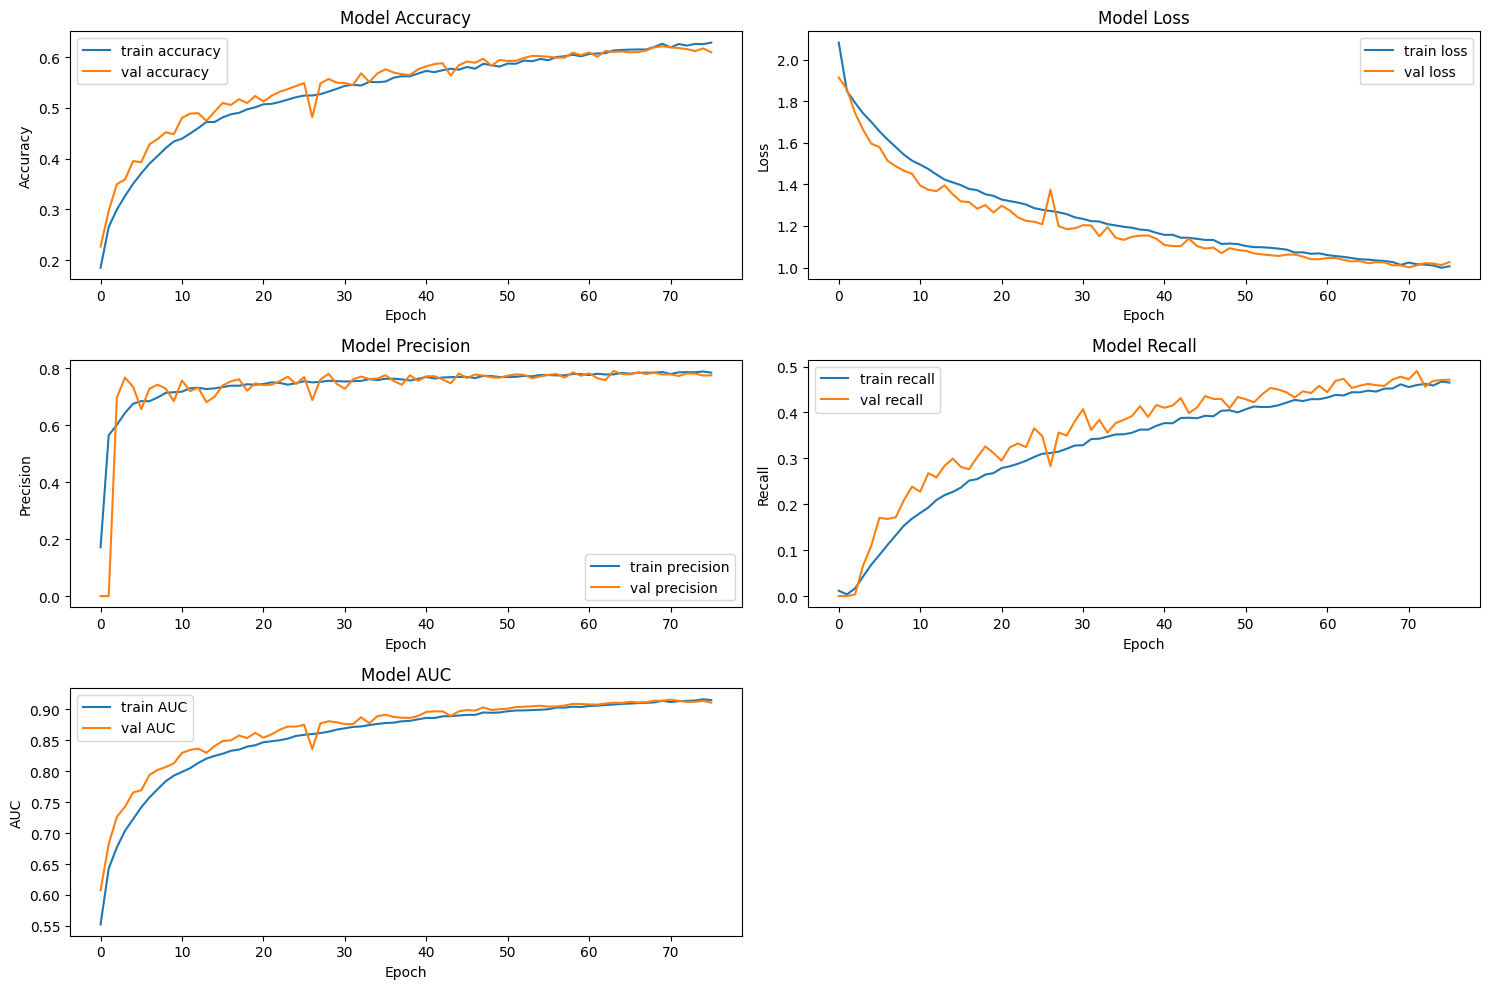

In [24]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()